The directories of Qian's experiment are listed as follows:

1/ wind + thermal perturbation run:
/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_qian_wthp

2/ wind + thermal +meltwater perturbation run:
/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_qian_wthmp

In [1]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr
import netCDF4 as nc

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import cmocean as cm

#From file of "Age at the Bottom of the Ocean"
from collections import OrderedDict
import cftime
import glob

#From file of "Cross-slope section"
# For gradient calculation (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm
# Load metpy module to obtain cross section (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

#From file of "barotropic streamfunction"
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning) 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client(n_workers=4)

# Load database
session = cc.database.create_session()

# Start a Cosima cookbook database session

In [3]:
# From file of "Exploring the COSIMA Cookbook"
from cosima_cookbook import explore

dbx = explore.DatabaseExplorer(session=session)
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

## Experiment:	01deg_jra55v13_ryf9091

Description:	0.1 degree ACCESS-OM2 global model configuration under the RYF9091 Repeat Year Forcing strategy outlined by Stewart et al. (2020), https://doi.org/10.1016/j.ocemod.2019.101557. The configuration is based on that described in Kiss et al. (2020), https://doi.org/10.5194/gmd-13-401-2020, but with many improvements. Initial conditions are WOA13v2 potential temperature and practical salinity. Run with JRA55-do v1.3 RYF9091 forcing. Spin up starts from a nominal year of 1 Jan 1900 and runs to 31 Dec 2100.

Notes:	Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1969 and 1 Jan 2086 to 31 Dec 2100

Contact:	Andy Hogg <andy.hogg@anu.edu.au>

No. files:	12671

Created:	2020-06-11

In [4]:
# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
temp_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00') - 273.15
salt_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')
ht_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', 
                          session=session, frequency='static', n=1)
area_t_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_t',  session=session, frequency='static', n=1)
st_edges_ocean_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')

# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_ryf = temp_ryf.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-31 00:00:00','2129-12-31 00:00:00'))
salt_ryf = salt_ryf.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-31 00:00:00','2129-12-31 00:00:00'))
ht_ryf = ht_ryf.sel(yt_ocean = slice(lat_min, lat_max))
area_t_ryf = area_t_ryf.sel(yt_ocean = slice(lat_min, lat_max))

# Select surface ocean:
temp_surface_ryf = temp_ryf.sel(st_ocean=0, method='nearest')
salt_surface_ryf = salt_ryf.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
temp_250m_ryf = temp_ryf.sel(st_ocean=250, method='nearest')
salt_250m_ryf = salt_ryf.sel(st_ocean=250, method='nearest')
# Select slice at sea floor (closest to 1000m depth):
temp_bottom_ryf = temp_ryf.sel(st_ocean=1000, method='nearest')
salt_bottom_ryf = salt_ryf.sel(st_ocean=1000, method='nearest')
# Weighted average with all depths
weights_st_ryf = salt_ryf.st_ocean
temp_st_ryf = temp_ryf.weighted(weights_st_ryf).mean('st_ocean')
salt_st_ryf = salt_ryf.weighted(weights_st_ryf).mean('st_ocean')

OperationalError: (sqlite3.OperationalError) no such column: ncattributes.name_id
[SQL: SELECT ncattributes.id AS ncattributes_id, ncattributes.ncvar_id AS ncattributes_ncvar_id, ncattributes.ncfile_id AS ncattributes_ncfile_id, ncattributes.name_id AS ncattributes_name_id, ncattributes.value_id AS ncattributes_value_id 
FROM ncattributes 
WHERE ? = ncattributes.ncvar_id]
[parameters: (2735106,)]
(Background on this error at: http://sqlalche.me/e/13/e3q8)

Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate Antarctic continental regions.

In [ ]:
land_mask_ryf = ~ht_ryf.isnull()
shelf_mask_ryf = (land_mask_ryf.where(ht_ryf < 1000))

#Put temp and salt into the shelf mask
temp_shelf_ryf = temp_ryf*shelf_mask_ryf
salt_shelf_ryf = salt_ryf*shelf_mask_ryf

## Experiment:	01deg_jra55v13_ryf9091_qian_wthp

Description:	Wind, thermal and humidity perturbation experiment based on CMIP6 future scenario (SSP5-8.5), plus meltwater perturbation

Notes:	If you require any further information, feel free to contact Qian.

Contact:	Qian Li <qian.li5@unsw.edu.au>

No. files:	410

Created:	2021-04-20

In [12]:
# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
temp_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00') - 273.15
salt_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')
ht_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='ht', 
                          session=session, frequency='static', n=1)
area_t_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='area_t',  session=session, frequency='static', n=1)
st_edges_ocean_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')

# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_wthp = temp_wthp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-31 00:00:00','2129-12-31 00:00:00'))
salt_wthp = salt_wthp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-31 00:00:00','2129-12-31 00:00:00'))
ht_wthp = ht_wthp.sel(yt_ocean = slice(lat_min, lat_max))
area_t_wthp = area_t_wthp.sel(yt_ocean = slice(lat_min, lat_max))

# Select surface ocean:
temp_surface_wthp = temp_wthp.sel(st_ocean=0, method='nearest')
salt_surface_wthp = salt_wthp.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
temp_250m_wthp = temp_wthp.sel(st_ocean=250, method='nearest')
salt_250m_wthp = salt_wthp.sel(st_ocean=250, method='nearest')
# Select slice at sea floor (closest to 1000m depth):
temp_bottom_wthp = temp_wthp.sel(st_ocean=1000, method='nearest')
salt_bottom_wthp = salt_wthp.sel(st_ocean=1000, method='nearest')
# Weighted average with all depths
weights_st_wthp = salt_wthp.st_ocean
temp_st_wthp = temp_wthp.weighted(weights_st_wthp).mean('st_ocean')
salt_st_wthp = salt_wthp.weighted(weights_st_wthp).mean('st_ocean')

Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate Antarctic continental regions.

In [13]:
land_mask_wthp = ~ht_wthp.isnull()
shelf_mask_wthp = (land_mask_wthp.where(ht_wthp < 1000))

#Put temp and salt into the shelf mask
temp_shelf_wthp = temp_wthp*shelf_mask_wthp
salt_shelf_wthp = salt_wthp*shelf_mask_wthp

## Experiment:	01deg_jra55v13_ryf9091_qian_wthmp

Description:	Wind, thermal and humidity perturbation experiment based on CMIP6 future scenario (SSP5-8.5)

Notes:	If you require any further information, feel free to contact Qian.

Contact:	Qian Li <qian.li5@unsw.edu.au>

No. files:	390

Created:	2021-04-20

In [14]:
# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
temp_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00') - 273.15
salt_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')
ht_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='ht', 
                          session=session, frequency='static', n=1)
area_t_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='area_t',  session=session, frequency='static', n=1)
st_edges_ocean_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2129-12-31 00:00:00')

# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_wthmp = temp_wthmp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2110-01-31 00:00:00','2129-12-31 00:00:00'))
salt_wthmp = salt_wthmp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2110-01-31 00:00:00','2129-12-31 00:00:00'))
ht_wthmp = ht_wthmp.sel(yt_ocean = slice(lat_min, lat_max))
area_t_wthmp = area_t_wthmp.sel(yt_ocean = slice(lat_min, lat_max))

# Select surface ocean:
temp_surface_wthmp = temp_wthmp.sel(st_ocean=0, method='nearest')
salt_surface_wthmp = salt_wthmp.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
temp_250m_wthmp = temp_wthmp.sel(st_ocean=250, method='nearest')
salt_250m_wthmp = salt_wthmp.sel(st_ocean=250, method='nearest')
# Select slice at sea floor (closest to 1000m depth):
temp_bottom_wthmp = temp_wthmp.sel(st_ocean=1000, method='nearest')
salt_bottom_wthmp = salt_wthmp.sel(st_ocean=1000, method='nearest')
# Weighted average with all depths
weights_st_wthmp = salt_wthmp.st_ocean
temp_st_wthmp = temp_wthmp.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_wthmp = salt_wthmp.weighted(weights_st_wthmp).mean('st_ocean')

Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate Antarctic continental regions.

In [15]:
land_mask_wthmp = ~ht_wthmp.isnull()
shelf_mask_wthmp = (land_mask_wthmp.where(ht_wthmp < 1000))

#Put temp and salt into the shelf mask
temp_shelf_wthmp = temp_wthmp*shelf_mask_wthmp
salt_shelf_wthmp = salt_wthmp*shelf_mask_wthmp

# Region Selection

Weddell Sea polynyas, Ross Sea polynya, Mertz Glacier polynya and Cape Darnley polynya are selected as four different shelf regions (surface, 250m and averaging over all depths) for comparison as a practice.

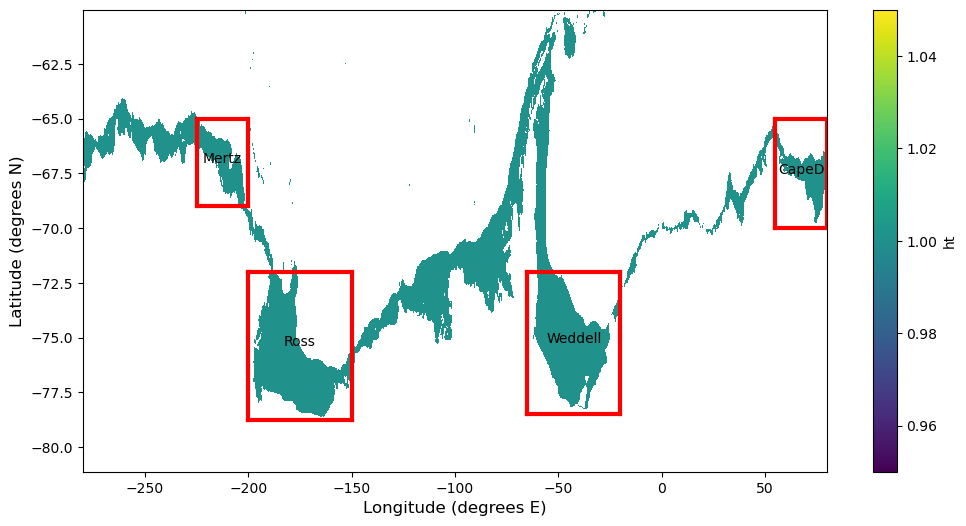

In [10]:
fig=plt.figure(2,(12,6))
ax = plt.subplot()
shelf_mask_wthp.plot() 
#or shelf_mask_ryf.plot()
#or shelf_mask_wthmp.plot()
plt.xlabel('Longitude (degrees E)', fontsize=12)
plt.ylabel('Latitude (degrees N)', fontsize=12)



#Weddell Sea coastal polynyas shelf region
bottomleft_lon=-65
bottomleft_lat=-78.5
topright_lon=-20
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Weddell', horizontalalignment='center')

temp_shelf_ryf_Weddell = temp_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in ryf experiment
temp_st_shelf_ryf_Weddell_weighted = temp_shelf_ryf_Weddell.weighted(weights_st_ryf).mean('st_ocean')
temp_st_shelf_ryf_Weddell = temp_st_shelf_ryf_Weddell_weighted.weighted(area_t_ryf.fillna(0))
temp_surface_shelf_ryf_Weddell = temp_shelf_ryf_Weddell.sel(st_ocean=0, method='nearest').weighted(area_t_ryf.fillna(0))
temp_250m_shelf_ryf_Weddell = temp_shelf_ryf_Weddell.sel(st_ocean=250, method='nearest').weighted(area_t_ryf.fillna(0))
temp_bottom_shelf_ryf_Weddell = temp_shelf_ryf_Weddell.sel(st_ocean=1000, method='nearest').weighted(area_t_ryf.fillna(0))

temp_shelf_wthp_Weddell = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthp experiment
temp_st_shelf_wthp_Weddell_weighted = temp_shelf_wthp_Weddell.weighted(weights_st_wthp).mean('st_ocean')
temp_st_shelf_wthp_Weddell = temp_st_shelf_wthp_Weddell_weighted.weighted(area_t_wthp.fillna(0))
temp_surface_shelf_wthp_Weddell = temp_shelf_wthp_Weddell.sel(st_ocean=0, method='nearest').weighted(area_t_wthp.fillna(0))
temp_250m_shelf_wthp_Weddell = temp_shelf_wthp_Weddell.sel(st_ocean=250, method='nearest').weighted(area_t_wthp.fillna(0))
temp_bottom_shelf_wthp_Weddell = temp_shelf_wthp_Weddell.sel(st_ocean=1000, method='nearest').weighted(area_t_wthp.fillna(0))

temp_shelf_wthmp_Weddell = temp_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthmp experiment
temp_st_shelf_wthmp_Weddell_weighted = temp_shelf_wthmp_Weddell.weighted(weights_st_wthmp).mean('st_ocean')
temp_st_shelf_wthmp_Weddell = temp_st_shelf_wthmp_Weddell_weighted.weighted(area_t_wthmp.fillna(0))
temp_surface_shelf_wthmp_Weddell = temp_shelf_wthmp_Weddell.sel(st_ocean=0, method='nearest').weighted(area_t_wthmp.fillna(0))
temp_250m_shelf_wthmp_Weddell = temp_shelf_wthmp_Weddell.sel(st_ocean=250, method='nearest').weighted(area_t_wthmp.fillna(0))
temp_bottom_shelf_wthmp_Weddell = temp_shelf_wthmp_Weddell.sel(st_ocean=1000, method='nearest').weighted(area_t_wthmp.fillna(0))

salt_shelf_ryf_Weddell = salt_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in ryf experiment
salt_st_shelf_ryf_Weddell_weighted = salt_shelf_ryf_Weddell.weighted(weights_st_ryf).mean('st_ocean')
salt_st_shelf_ryf_Weddell = salt_st_shelf_ryf_Weddell_weighted.weighted(area_t_ryf.fillna(0))
salt_surface_shelf_ryf_Weddell = salt_shelf_ryf_Weddell.sel(st_ocean=0, method='nearest').weighted(area_t_ryf.fillna(0))
salt_250m_shelf_ryf_Weddell = salt_shelf_ryf_Weddell.sel(st_ocean=250, method='nearest').weighted(area_t_ryf.fillna(0))
salt_bottom_shelf_ryf_Weddell = salt_shelf_ryf_Weddell.sel(st_ocean=1000, method='nearest').weighted(area_t_ryf.fillna(0))

salt_shelf_wthp_Weddell = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthp experiment
salt_st_shelf_wthp_Weddell_weighted = salt_shelf_wthp_Weddell.weighted(weights_st_wthp).mean('st_ocean')
salt_st_shelf_wthp_Weddell = salt_st_shelf_wthp_Weddell_weighted.weighted(area_t_wthp.fillna(0))
salt_surface_shelf_wthp_Weddell = salt_shelf_wthp_Weddell.sel(st_ocean=0, method='nearest').weighted(area_t_wthp.fillna(0))
salt_250m_shelf_wthp_Weddell = salt_shelf_wthp_Weddell.sel(st_ocean=250, method='nearest').weighted(area_t_wthp.fillna(0))
salt_bottom_shelf_wthp_Weddell = salt_shelf_wthp_Weddell.sel(st_ocean=1000, method='nearest').weighted(area_t_wthp.fillna(0))

salt_shelf_wthmp_Weddell = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthmp experiment
salt_st_shelf_wthmp_Weddell_weighted = salt_shelf_wthmp_Weddell.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_shelf_wthmp_Weddell = salt_st_shelf_wthmp_Weddell_weighted.weighted(area_t_wthmp.fillna(0))
salt_surface_shelf_wthmp_Weddell = salt_shelf_wthmp_Weddell.sel(st_ocean=0, method='nearest').weighted(area_t_wthmp.fillna(0))
salt_250m_shelf_wthmp_Weddell = salt_shelf_wthmp_Weddell.sel(st_ocean=250, method='nearest').weighted(area_t_wthmp.fillna(0))
salt_bottom_shelf_wthmp_Weddell = salt_shelf_wthmp_Weddell.sel(st_ocean=1000, method='nearest').weighted(area_t_wthmp.fillna(0))



#Ross Sea coastal polynya shelf region
bottomleft_lon=-200
bottomleft_lat=-78.75
topright_lon=-150
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Ross', horizontalalignment='center')

temp_shelf_ryf_Ross = temp_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in ryf experiment
temp_st_shelf_ryf_Ross_weighted = temp_shelf_ryf_Ross.weighted(weights_st_ryf).mean('st_ocean')
temp_st_shelf_ryf_Ross = temp_st_shelf_ryf_Ross_weighted.weighted(area_t_ryf.fillna(0))
temp_surface_shelf_ryf_Ross = temp_shelf_ryf_Ross.sel(st_ocean=0, method='nearest').weighted(area_t_ryf.fillna(0))
temp_250m_shelf_ryf_Ross = temp_shelf_ryf_Ross.sel(st_ocean=250, method='nearest').weighted(area_t_ryf.fillna(0))
temp_bottom_shelf_ryf_Ross = temp_shelf_ryf_Ross.sel(st_ocean=1000, method='nearest').weighted(area_t_ryf.fillna(0))

temp_shelf_wthp_Ross = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthp experiment
temp_st_shelf_wthp_Ross_weighted = temp_shelf_wthp_Ross.weighted(weights_st_wthp).mean('st_ocean')
temp_st_shelf_wthp_Ross = temp_st_shelf_wthp_Ross_weighted.weighted(area_t_wthp.fillna(0))
temp_surface_shelf_wthp_Ross = temp_shelf_wthp_Ross.sel(st_ocean=0, method='nearest').weighted(area_t_wthp.fillna(0))
temp_250m_shelf_wthp_Ross = temp_shelf_wthp_Ross.sel(st_ocean=250, method='nearest').weighted(area_t_wthp.fillna(0))
temp_bottom_shelf_wthp_Ross = temp_shelf_wthp_Ross.sel(st_ocean=1000, method='nearest').weighted(area_t_wthp.fillna(0))

temp_shelf_wthmp_Ross = temp_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthmp experiment
temp_st_shelf_wthmp_Ross_weighted = temp_shelf_wthmp_Ross.weighted(weights_st_wthmp).mean('st_ocean')
temp_st_shelf_wthmp_Ross = temp_st_shelf_wthmp_Ross_weighted.weighted(area_t_wthmp.fillna(0))
temp_surface_shelf_wthmp_Ross = temp_shelf_wthmp_Ross.sel(st_ocean=0, method='nearest').weighted(area_t_wthmp.fillna(0))
temp_250m_shelf_wthmp_Ross = temp_shelf_wthmp_Ross.sel(st_ocean=250, method='nearest').weighted(area_t_wthmp.fillna(0))
temp_bottom_shelf_wthmp_Ross = temp_shelf_wthmp_Ross.sel(st_ocean=1000, method='nearest').weighted(area_t_wthmp.fillna(0))

salt_shelf_ryf_Ross = salt_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in ryf experiment
salt_st_shelf_ryf_Ross_weighted = salt_shelf_ryf_Ross.weighted(weights_st_ryf).mean('st_ocean')
salt_st_shelf_ryf_Ross = salt_st_shelf_ryf_Ross_weighted.weighted(area_t_ryf.fillna(0))
salt_surface_shelf_ryf_Ross = salt_shelf_ryf_Ross.sel(st_ocean=0, method='nearest').weighted(area_t_ryf.fillna(0))
salt_250m_shelf_ryf_Ross = salt_shelf_ryf_Ross.sel(st_ocean=250, method='nearest').weighted(area_t_ryf.fillna(0))
salt_bottom_shelf_ryf_Ross = salt_shelf_ryf_Ross.sel(st_ocean=1000, method='nearest').weighted(area_t_ryf.fillna(0))

salt_shelf_wthp_Ross = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthp experiment
salt_st_shelf_wthp_Ross_weighted = salt_shelf_wthp_Ross.weighted(weights_st_wthp).mean('st_ocean')
salt_st_shelf_wthp_Ross = salt_st_shelf_wthp_Ross_weighted.weighted(area_t_wthp.fillna(0))
salt_surface_shelf_wthp_Ross = salt_shelf_wthp_Ross.sel(st_ocean=0, method='nearest').weighted(area_t_wthp.fillna(0))
salt_250m_shelf_wthp_Ross = salt_shelf_wthp_Ross.sel(st_ocean=250, method='nearest').weighted(area_t_wthp.fillna(0))
salt_bottom_shelf_wthp_Ross = salt_shelf_wthp_Ross.sel(st_ocean=1000, method='nearest').weighted(area_t_wthp.fillna(0))

salt_shelf_wthmp_Ross = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthmp experiment
salt_st_shelf_wthmp_Ross_weighted = salt_shelf_wthmp_Ross.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_shelf_wthmp_Ross = salt_st_shelf_wthmp_Ross_weighted.weighted(area_t_wthmp.fillna(0))
salt_surface_shelf_wthmp_Ross = salt_shelf_wthmp_Ross.sel(st_ocean=0, method='nearest').weighted(area_t_wthmp.fillna(0))
salt_250m_shelf_wthmp_Ross = salt_shelf_wthmp_Ross.sel(st_ocean=250, method='nearest').weighted(area_t_wthmp.fillna(0))
salt_bottom_shelf_wthmp_Ross = salt_shelf_wthmp_Ross.sel(st_ocean=1000, method='nearest').weighted(area_t_wthmp.fillna(0))


#Cape Darnley polynya shelf region
bottomleft_lon=55
bottomleft_lat=-70
topright_lon=80
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'CapeD', horizontalalignment='center')

temp_shelf_ryf_CapeD = temp_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in ryf experiment
temp_st_shelf_ryf_CapeD_weighted = temp_shelf_ryf_CapeD.weighted(weights_st_ryf).mean('st_ocean')
temp_st_shelf_ryf_CapeD = temp_st_shelf_ryf_CapeD_weighted.weighted(area_t_ryf.fillna(0))
temp_surface_shelf_ryf_CapeD = temp_shelf_ryf_CapeD.sel(st_ocean=0, method='nearest').weighted(area_t_ryf.fillna(0))
temp_250m_shelf_ryf_CapeD = temp_shelf_ryf_CapeD.sel(st_ocean=250, method='nearest').weighted(area_t_ryf.fillna(0))
temp_bottom_shelf_ryf_CapeD = temp_shelf_ryf_CapeD.sel(st_ocean=1000, method='nearest').weighted(area_t_ryf.fillna(0))

temp_shelf_wthp_CapeD = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthp experiment
temp_st_shelf_wthp_CapeD_weighted = temp_shelf_wthp_CapeD.weighted(weights_st_wthp).mean('st_ocean')
temp_st_shelf_wthp_CapeD = temp_st_shelf_wthp_CapeD_weighted.weighted(area_t_wthp.fillna(0))
temp_surface_shelf_wthp_CapeD = temp_shelf_wthp_CapeD.sel(st_ocean=0, method='nearest').weighted(area_t_wthp.fillna(0))
temp_250m_shelf_wthp_CapeD = temp_shelf_wthp_CapeD.sel(st_ocean=250, method='nearest').weighted(area_t_wthp.fillna(0))
temp_bottom_shelf_wthp_CapeD = temp_shelf_wthp_CapeD.sel(st_ocean=1000, method='nearest').weighted(area_t_wthp.fillna(0))

temp_shelf_wthmp_CapeD = temp_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthmp experiment
temp_st_shelf_wthmp_CapeD_weighted = temp_shelf_wthmp_CapeD.weighted(weights_st_wthmp).mean('st_ocean')
temp_st_shelf_wthmp_CapeD = temp_st_shelf_wthmp_CapeD_weighted.weighted(area_t_wthmp.fillna(0))
temp_surface_shelf_wthmp_CapeD = temp_shelf_wthmp_CapeD.sel(st_ocean=0, method='nearest').weighted(area_t_wthmp.fillna(0))
temp_250m_shelf_wthmp_CapeD = temp_shelf_wthmp_CapeD.sel(st_ocean=250, method='nearest').weighted(area_t_wthmp.fillna(0))
temp_bottom_shelf_wthmp_CapeD = temp_shelf_wthmp_CapeD.sel(st_ocean=1000, method='nearest').weighted(area_t_wthmp.fillna(0))

salt_shelf_ryf_CapeD = salt_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in ryf experiment
salt_st_shelf_ryf_CapeD_weighted = salt_shelf_ryf_CapeD.weighted(weights_st_ryf).mean('st_ocean')
salt_st_shelf_ryf_CapeD = salt_st_shelf_ryf_CapeD_weighted.weighted(area_t_ryf.fillna(0))
salt_surface_shelf_ryf_CapeD = salt_shelf_ryf_CapeD.sel(st_ocean=0, method='nearest').weighted(area_t_ryf.fillna(0))
salt_250m_shelf_ryf_CapeD = salt_shelf_ryf_CapeD.sel(st_ocean=250, method='nearest').weighted(area_t_ryf.fillna(0))
salt_bottom_shelf_ryf_CapeD = salt_shelf_ryf_CapeD.sel(st_ocean=1000, method='nearest').weighted(area_t_ryf.fillna(0))

salt_shelf_wthp_CapeD = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthp experiment
salt_st_shelf_wthp_CapeD_weighted = salt_shelf_wthp_CapeD.weighted(weights_st_wthp).mean('st_ocean')
salt_st_shelf_wthp_CapeD = salt_st_shelf_wthp_CapeD_weighted.weighted(area_t_wthp.fillna(0))
salt_surface_shelf_wthp_CapeD = salt_shelf_wthp_CapeD.sel(st_ocean=0, method='nearest').weighted(area_t_wthp.fillna(0))
salt_250m_shelf_wthp_CapeD = salt_shelf_wthp_CapeD.sel(st_ocean=250, method='nearest').weighted(area_t_wthp.fillna(0))
salt_bottom_shelf_wthp_CapeD = salt_shelf_wthp_CapeD.sel(st_ocean=1000, method='nearest').weighted(area_t_wthp.fillna(0))

salt_shelf_wthmp_CapeD = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthmp experiment
salt_st_shelf_wthmp_CapeD_weighted = salt_shelf_wthmp_CapeD.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_shelf_wthmp_CapeD = salt_st_shelf_wthmp_CapeD_weighted.weighted(area_t_wthmp.fillna(0))
salt_surface_shelf_wthmp_CapeD = salt_shelf_wthmp_CapeD.sel(st_ocean=0, method='nearest').weighted(area_t_wthmp.fillna(0))
salt_250m_shelf_wthmp_CapeD = salt_shelf_wthmp_CapeD.sel(st_ocean=250, method='nearest').weighted(area_t_wthmp.fillna(0))
salt_bottom_shelf_wthmp_CapeD = salt_shelf_wthmp_CapeD.sel(st_ocean=1000, method='nearest').weighted(area_t_wthmp.fillna(0))




#Mertz Glacier Polynya shelf region
bottomleft_lon=-225
bottomleft_lat=-69
topright_lon=-200
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, 'Mertz', horizontalalignment='center')

temp_shelf_ryf_Mertz = temp_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in ryf experiment
temp_st_shelf_ryf_Mertz_weighted = temp_shelf_ryf_Mertz.weighted(weights_st_ryf).mean('st_ocean')
temp_st_shelf_ryf_Mertz = temp_st_shelf_ryf_Mertz_weighted.weighted(area_t_ryf.fillna(0))
temp_surface_shelf_ryf_Mertz = temp_shelf_ryf_Mertz.sel(st_ocean=0, method='nearest').weighted(area_t_ryf.fillna(0))
temp_250m_shelf_ryf_Mertz = temp_shelf_ryf_Mertz.sel(st_ocean=250, method='nearest').weighted(area_t_ryf.fillna(0))
temp_bottom_shelf_ryf_Mertz = temp_shelf_ryf_Mertz.sel(st_ocean=1000, method='nearest').weighted(area_t_ryf.fillna(0))

temp_shelf_wthp_Mertz = temp_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthp experiment
temp_st_shelf_wthp_Mertz_weighted = temp_shelf_wthp_Mertz.weighted(weights_st_wthp).mean('st_ocean')
temp_st_shelf_wthp_Mertz = temp_st_shelf_wthp_Mertz_weighted.weighted(area_t_wthp.fillna(0))
temp_surface_shelf_wthp_Mertz = temp_shelf_wthp_Mertz.sel(st_ocean=0, method='nearest').weighted(area_t_wthp.fillna(0))
temp_250m_shelf_wthp_Mertz = temp_shelf_wthp_Mertz.sel(st_ocean=250, method='nearest').weighted(area_t_wthp.fillna(0))
temp_bottom_shelf_wthp_Mertz = temp_shelf_wthp_Mertz.sel(st_ocean=1000, method='nearest').weighted(area_t_wthp.fillna(0))

temp_shelf_wthmp_Mertz = temp_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of temp in wthmp experiment
temp_st_shelf_wthmp_Mertz_weighted = temp_shelf_wthmp_Mertz.weighted(weights_st_wthmp).mean('st_ocean')
temp_st_shelf_wthmp_Mertz = temp_st_shelf_wthmp_Mertz_weighted.weighted(area_t_wthmp.fillna(0))
temp_surface_shelf_wthmp_Mertz = temp_shelf_wthmp_Mertz.sel(st_ocean=0, method='nearest').weighted(area_t_wthmp.fillna(0))
temp_250m_shelf_wthmp_Mertz = temp_shelf_wthmp_Mertz.sel(st_ocean=250, method='nearest').weighted(area_t_wthmp.fillna(0))
temp_bottom_shelf_wthmp_Mertz = temp_shelf_wthmp_Mertz.sel(st_ocean=1000, method='nearest').weighted(area_t_wthmp.fillna(0))

salt_shelf_ryf_Mertz = salt_shelf_ryf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in ryf experiment
salt_st_shelf_ryf_Mertz_weighted = salt_shelf_ryf_Mertz.weighted(weights_st_ryf).mean('st_ocean')
salt_st_shelf_ryf_Mertz = salt_st_shelf_ryf_Mertz_weighted.weighted(area_t_ryf.fillna(0))
salt_surface_shelf_ryf_Mertz = salt_shelf_ryf_Mertz.sel(st_ocean=0, method='nearest').weighted(area_t_ryf.fillna(0))
salt_250m_shelf_ryf_Mertz = salt_shelf_ryf_Mertz.sel(st_ocean=250, method='nearest').weighted(area_t_ryf.fillna(0))
salt_bottom_shelf_ryf_Mertz = salt_shelf_ryf_Mertz.sel(st_ocean=1000, method='nearest').weighted(area_t_ryf.fillna(0))

salt_shelf_wthp_Mertz = salt_shelf_wthp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthp experiment
salt_st_shelf_wthp_Mertz_weighted = salt_shelf_wthp_Mertz.weighted(weights_st_wthp).mean('st_ocean')
salt_st_shelf_wthp_Mertz = salt_st_shelf_wthp_Mertz_weighted.weighted(area_t_wthp.fillna(0))
salt_surface_shelf_wthp_Mertz = salt_shelf_wthp_Mertz.sel(st_ocean=0, method='nearest').weighted(area_t_wthp.fillna(0))
salt_250m_shelf_wthp_Mertz = salt_shelf_wthp_Mertz.sel(st_ocean=250, method='nearest').weighted(area_t_wthp.fillna(0))
salt_bottom_shelf_wthp_Mertz = salt_shelf_wthp_Mertz.sel(st_ocean=1000, method='nearest').weighted(area_t_wthp.fillna(0))

salt_shelf_wthmp_Mertz = salt_shelf_wthmp.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages of salt in wthmp experiment
salt_st_shelf_wthmp_Mertz_weighted = salt_shelf_wthmp_Mertz.weighted(weights_st_wthmp).mean('st_ocean')
salt_st_shelf_wthmp_Mertz = salt_st_shelf_wthmp_Mertz_weighted.weighted(area_t_wthmp.fillna(0))
salt_surface_shelf_wthmp_Mertz = salt_shelf_wthmp_Mertz.sel(st_ocean=0, method='nearest').weighted(area_t_wthmp.fillna(0))
salt_250m_shelf_wthmp_Mertz = salt_shelf_wthmp_Mertz.sel(st_ocean=250, method='nearest').weighted(area_t_wthmp.fillna(0))
salt_bottom_shelf_wthmp_Mertz = salt_shelf_wthmp_Mertz.sel(st_ocean=1000, method='nearest').weighted(area_t_wthmp.fillna(0))

In [11]:
#Create time series for different regions by averaging over lon-lat (359 months)
temp_st_shelf_ryf_Weddell_mean = temp_st_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthp_Weddell_mean = temp_st_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthmp_Weddell_mean = temp_st_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_ryf_Weddell_mean = salt_st_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthp_Weddell_mean = salt_st_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthmp_Weddell_mean = salt_st_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_ryf_Ross_mean = temp_st_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthp_Ross_mean = temp_st_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthmp_Ross_mean = temp_st_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_ryf_Ross_mean = salt_st_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthp_Ross_mean = salt_st_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthmp_Ross_mean = salt_st_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_ryf_CapeD_mean = temp_st_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthp_CapeD_mean = temp_st_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthmp_CapeD_mean = temp_st_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_ryf_CapeD_mean = salt_st_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthp_CapeD_mean = salt_st_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthmp_CapeD_mean = salt_st_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_ryf_Mertz_mean = temp_st_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthp_Mertz_mean = temp_st_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_wthmp_Mertz_mean = temp_st_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_ryf_Mertz_mean = salt_st_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthp_Mertz_mean = salt_st_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_wthmp_Mertz_mean = salt_st_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))

temp_surface_shelf_ryf_Weddell_mean = temp_surface_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthp_Weddell_mean = temp_surface_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthmp_Weddell_mean = temp_surface_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_ryf_Weddell_mean = salt_surface_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthp_Weddell_mean = salt_surface_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthmp_Weddell_mean = salt_surface_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_ryf_Ross_mean = temp_surface_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthp_Ross_mean = temp_surface_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthmp_Ross_mean = temp_surface_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_ryf_Ross_mean = salt_surface_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthp_Ross_mean = salt_surface_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthmp_Ross_mean = salt_surface_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_ryf_CapeD_mean = temp_surface_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthp_CapeD_mean = temp_surface_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthmp_CapeD_mean = temp_surface_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_ryf_CapeD_mean = salt_surface_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthp_CapeD_mean = salt_surface_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthmp_CapeD_mean = salt_surface_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_ryf_Mertz_mean = temp_surface_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthp_Mertz_mean = temp_surface_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_wthmp_Mertz_mean = temp_surface_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_ryf_Mertz_mean = salt_surface_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthp_Mertz_mean = salt_surface_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_wthmp_Mertz_mean = salt_surface_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))

temp_250m_shelf_ryf_Weddell_mean = temp_250m_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthp_Weddell_mean = temp_250m_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthmp_Weddell_mean = temp_250m_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_ryf_Weddell_mean = salt_250m_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthp_Weddell_mean = salt_250m_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthmp_Weddell_mean = salt_250m_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_ryf_Ross_mean = temp_250m_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthp_Ross_mean = temp_250m_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthmp_Ross_mean = temp_250m_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_ryf_Ross_mean = salt_250m_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthp_Ross_mean = salt_250m_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthmp_Ross_mean = salt_250m_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_ryf_CapeD_mean = temp_250m_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthp_CapeD_mean = temp_250m_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthmp_CapeD_mean = temp_250m_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_ryf_CapeD_mean = salt_250m_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthp_CapeD_mean = salt_250m_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthmp_CapeD_mean = salt_250m_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_ryf_Mertz_mean = temp_250m_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthp_Mertz_mean = temp_250m_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_wthmp_Mertz_mean = temp_250m_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_ryf_Mertz_mean = salt_250m_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthp_Mertz_mean = salt_250m_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_wthmp_Mertz_mean = salt_250m_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))

temp_bottom_shelf_ryf_Weddell_mean = temp_bottom_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthp_Weddell_mean = temp_bottom_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthmp_Weddell_mean = temp_bottom_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_ryf_Weddell_mean = salt_bottom_shelf_ryf_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthp_Weddell_mean = salt_bottom_shelf_wthp_Weddell.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthmp_Weddell_mean = salt_bottom_shelf_wthmp_Weddell.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_ryf_Ross_mean = temp_bottom_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthp_Ross_mean = temp_bottom_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthmp_Ross_mean = temp_bottom_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_ryf_Ross_mean = salt_bottom_shelf_ryf_Ross.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthp_Ross_mean = salt_bottom_shelf_wthp_Ross.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthmp_Ross_mean = salt_bottom_shelf_wthmp_Ross.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_ryf_CapeD_mean = temp_bottom_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthp_CapeD_mean = temp_bottom_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthmp_CapeD_mean = temp_bottom_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_ryf_CapeD_mean = salt_bottom_shelf_ryf_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthp_CapeD_mean = salt_bottom_shelf_wthp_CapeD.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthmp_CapeD_mean = salt_bottom_shelf_wthmp_CapeD.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_ryf_Mertz_mean = temp_bottom_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthp_Mertz_mean = temp_bottom_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_wthmp_Mertz_mean = temp_bottom_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_ryf_Mertz_mean = salt_bottom_shelf_ryf_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthp_Mertz_mean = salt_bottom_shelf_wthp_Mertz.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_wthmp_Mertz_mean = salt_bottom_shelf_wthmp_Mertz.mean(("xt_ocean", "yt_ocean"))

#Example
temp_st_shelf_ryf_Weddell_mean

<xarray.DataArray (time: 359)>
dask.array<truediv, shape=(359,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2100-02-15 00:00:00 ... 2129-12-16 12:00:00

In [12]:
#Create annual average time series for different regions (30 yrs)
temp_st_shelf_ryf_Weddell_mean_annual = temp_st_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_Weddell_mean_annual = temp_st_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_Weddell_mean_annual = temp_st_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_Weddell_mean_annual = salt_st_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_Weddell_mean_annual = salt_st_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_Weddell_mean_annual = salt_st_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_ryf_Ross_mean_annual = temp_st_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_Ross_mean_annual = temp_st_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_Ross_mean_annual = temp_st_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_Ross_mean_annual = salt_st_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_Ross_mean_annual = salt_st_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_Ross_mean_annual = salt_st_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_ryf_CapeD_mean_annual = temp_st_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_CapeD_mean_annual = temp_st_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_CapeD_mean_annual = temp_st_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_CapeD_mean_annual = salt_st_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_CapeD_mean_annual = salt_st_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_CapeD_mean_annual = salt_st_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_ryf_Mertz_mean_annual = temp_st_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_Mertz_mean_annual = temp_st_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_Mertz_mean_annual = temp_st_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_Mertz_mean_annual = salt_st_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_Mertz_mean_annual = salt_st_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_Mertz_mean_annual = salt_st_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')

temp_surface_shelf_ryf_Weddell_mean_annual = temp_surface_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_Weddell_mean_annual = temp_surface_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_Weddell_mean_annual = temp_surface_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_Weddell_mean_annual = salt_surface_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_Weddell_mean_annual = salt_surface_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_Weddell_mean_annual = salt_surface_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_ryf_Ross_mean_annual = temp_surface_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_Ross_mean_annual = temp_surface_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_Ross_mean_annual = temp_surface_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_Ross_mean_annual = salt_surface_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_Ross_mean_annual = salt_surface_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_Ross_mean_annual = salt_surface_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_ryf_CapeD_mean_annual = temp_surface_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_CapeD_mean_annual = temp_surface_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_CapeD_mean_annual = temp_surface_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_CapeD_mean_annual = salt_surface_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_CapeD_mean_annual = salt_surface_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_CapeD_mean_annual = salt_surface_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_ryf_Mertz_mean_annual = temp_surface_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_Mertz_mean_annual = temp_surface_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_Mertz_mean_annual = temp_surface_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_Mertz_mean_annual = salt_surface_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_Mertz_mean_annual = salt_surface_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_Mertz_mean_annual = salt_surface_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')

temp_250m_shelf_ryf_Weddell_mean_annual = temp_250m_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_Weddell_mean_annual = temp_250m_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_Weddell_mean_annual = temp_250m_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_Weddell_mean_annual = salt_250m_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_Weddell_mean_annual = salt_250m_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_Weddell_mean_annual = salt_250m_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf_Ross_mean_annual = temp_250m_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_Ross_mean_annual = temp_250m_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_Ross_mean_annual = temp_250m_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_Ross_mean_annual = salt_250m_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_Ross_mean_annual = salt_250m_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_Ross_mean_annual = salt_250m_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf_CapeD_mean_annual = temp_250m_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_CapeD_mean_annual = temp_250m_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_CapeD_mean_annual = temp_250m_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_CapeD_mean_annual = salt_250m_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_CapeD_mean_annual = salt_250m_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_CapeD_mean_annual = salt_250m_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf_Mertz_mean_annual = temp_250m_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_Mertz_mean_annual = temp_250m_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_Mertz_mean_annual = temp_250m_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_Mertz_mean_annual = salt_250m_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_Mertz_mean_annual = salt_250m_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_Mertz_mean_annual = salt_250m_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')

temp_bottom_shelf_ryf_Weddell_mean_annual = temp_bottom_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_Weddell_mean_annual = temp_bottom_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_Weddell_mean_annual = temp_bottom_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_Weddell_mean_annual = salt_bottom_shelf_ryf_Weddell_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_Weddell_mean_annual = salt_bottom_shelf_wthp_Weddell_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_Weddell_mean_annual = salt_bottom_shelf_wthmp_Weddell_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_ryf_Ross_mean_annual = temp_bottom_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_Ross_mean_annual = temp_bottom_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_Ross_mean_annual = temp_bottom_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_Ross_mean_annual = salt_bottom_shelf_ryf_Ross_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_Ross_mean_annual = salt_bottom_shelf_wthp_Ross_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_Ross_mean_annual = salt_bottom_shelf_wthmp_Ross_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_ryf_CapeD_mean_annual = temp_bottom_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_CapeD_mean_annual = temp_bottom_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_CapeD_mean_annual = temp_bottom_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_CapeD_mean_annual = salt_bottom_shelf_ryf_CapeD_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_CapeD_mean_annual = salt_bottom_shelf_wthp_CapeD_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_CapeD_mean_annual = salt_bottom_shelf_wthmp_CapeD_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_ryf_Mertz_mean_annual = temp_bottom_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_Mertz_mean_annual = temp_bottom_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_Mertz_mean_annual = temp_bottom_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_Mertz_mean_annual = salt_bottom_shelf_ryf_Mertz_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_Mertz_mean_annual = salt_bottom_shelf_wthp_Mertz_mean.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_Mertz_mean_annual = salt_bottom_shelf_wthmp_Mertz_mean.groupby('time.year').mean(dim='time')

#Example
temp_st_shelf_ryf_Weddell_mean_annual

<xarray.DataArray (year: 30)>
dask.array<stack, shape=(30,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 2100 2101 2102 2103 2104 ... 2125 2126 2127 2128 2129

In [13]:
#Now create a monthly climatology for 1950-1980 period
temp_st_shelf_ryf_Weddell_clim = temp_st_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_wthp_Weddell_clim = temp_st_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_wthmp_Weddell_clim = temp_st_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_ryf_Weddell_clim = salt_st_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_wthp_Weddell_clim = salt_st_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_wthmp_Weddell_clim = salt_st_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_ryf_Ross_clim = temp_st_shelf_ryf_Ross_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_wthp_Ross_clim = temp_st_shelf_wthp_Ross_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_wthmp_Ross_clim = temp_st_shelf_wthmp_Ross_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_ryf_Ross_clim = salt_st_shelf_ryf_Ross_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_wthp_Ross_clim = salt_st_shelf_wthp_Ross_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_wthmp_Ross_clim = salt_st_shelf_wthmp_Ross_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_ryf_CapeD_clim = temp_st_shelf_ryf_CapeD_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_wthp_CapeD_clim = temp_st_shelf_wthp_CapeD_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_wthmp_CapeD_clim = temp_st_shelf_wthmp_CapeD_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_ryf_CapeD_clim = salt_st_shelf_ryf_CapeD_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_wthp_CapeD_clim = salt_st_shelf_wthp_CapeD_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_wthmp_CapeD_clim = salt_st_shelf_wthmp_CapeD_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_ryf_Mertz_clim = temp_st_shelf_ryf_Mertz_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_wthp_Mertz_clim = temp_st_shelf_wthp_Mertz_mean.groupby('time.month').mean(dim='time')
temp_st_shelf_wthmp_Mertz_clim = temp_st_shelf_wthmp_Mertz_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_ryf_Mertz_clim = salt_st_shelf_ryf_Mertz_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_wthp_Mertz_clim = salt_st_shelf_wthp_Mertz_mean.groupby('time.month').mean(dim='time')
salt_st_shelf_wthmp_Mertz_clim = salt_st_shelf_wthmp_Mertz_mean.groupby('time.month').mean(dim='time')

temp_surface_shelf_ryf_Weddell_clim = temp_surface_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_wthp_Weddell_clim = temp_surface_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_wthmp_Weddell_clim = temp_surface_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_ryf_Weddell_clim = salt_surface_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_wthp_Weddell_clim = salt_surface_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_wthmp_Weddell_clim = salt_surface_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_ryf_Ross_clim = temp_surface_shelf_ryf_Ross_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_wthp_Ross_clim = temp_surface_shelf_wthp_Ross_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_wthmp_Ross_clim = temp_surface_shelf_wthmp_Ross_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_ryf_Ross_clim = salt_surface_shelf_ryf_Ross_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_wthp_Ross_clim = salt_surface_shelf_wthp_Ross_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_wthmp_Ross_clim = salt_surface_shelf_wthmp_Ross_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_ryf_CapeD_clim = temp_surface_shelf_ryf_CapeD_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_wthp_CapeD_clim = temp_surface_shelf_wthp_CapeD_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_wthmp_CapeD_clim = temp_surface_shelf_wthmp_CapeD_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_ryf_CapeD_clim = salt_surface_shelf_ryf_CapeD_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_wthp_CapeD_clim = salt_surface_shelf_wthp_CapeD_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_wthmp_CapeD_clim = salt_surface_shelf_wthmp_CapeD_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_ryf_Mertz_clim = temp_surface_shelf_ryf_Mertz_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_wthp_Mertz_clim = temp_surface_shelf_wthp_Mertz_mean.groupby('time.month').mean(dim='time')
temp_surface_shelf_wthmp_Mertz_clim = temp_surface_shelf_wthmp_Mertz_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_ryf_Mertz_clim = salt_surface_shelf_ryf_Mertz_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_wthp_Mertz_clim = salt_surface_shelf_wthp_Mertz_mean.groupby('time.month').mean(dim='time')
salt_surface_shelf_wthmp_Mertz_clim = salt_surface_shelf_wthmp_Mertz_mean.groupby('time.month').mean(dim='time')

temp_250m_shelf_ryf_Weddell_clim = temp_250m_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_wthp_Weddell_clim = temp_250m_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_wthmp_Weddell_clim = temp_250m_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_ryf_Weddell_clim = salt_250m_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_wthp_Weddell_clim = salt_250m_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_wthmp_Weddell_clim = salt_250m_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_ryf_Ross_clim = temp_250m_shelf_ryf_Ross_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_wthp_Ross_clim = temp_250m_shelf_wthp_Ross_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_wthmp_Ross_clim = temp_250m_shelf_wthmp_Ross_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_ryf_Ross_clim = salt_250m_shelf_ryf_Ross_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_wthp_Ross_clim = salt_250m_shelf_wthp_Ross_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_wthmp_Ross_clim = salt_250m_shelf_wthmp_Ross_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_ryf_CapeD_clim = temp_250m_shelf_ryf_CapeD_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_wthp_CapeD_clim = temp_250m_shelf_wthp_CapeD_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_wthmp_CapeD_clim = temp_250m_shelf_wthmp_CapeD_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_ryf_CapeD_clim = salt_250m_shelf_ryf_CapeD_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_wthp_CapeD_clim = salt_250m_shelf_wthp_CapeD_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_wthmp_CapeD_clim = salt_250m_shelf_wthmp_CapeD_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_ryf_Mertz_clim = temp_250m_shelf_ryf_Mertz_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_wthp_Mertz_clim = temp_250m_shelf_wthp_Mertz_mean.groupby('time.month').mean(dim='time')
temp_250m_shelf_wthmp_Mertz_clim = temp_250m_shelf_wthmp_Mertz_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_ryf_Mertz_clim = salt_250m_shelf_ryf_Mertz_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_wthp_Mertz_clim = salt_250m_shelf_wthp_Mertz_mean.groupby('time.month').mean(dim='time')
salt_250m_shelf_wthmp_Mertz_clim = salt_250m_shelf_wthmp_Mertz_mean.groupby('time.month').mean(dim='time')

temp_bottom_shelf_ryf_Weddell_clim = temp_bottom_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_wthp_Weddell_clim = temp_bottom_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_wthmp_Weddell_clim = temp_bottom_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_ryf_Weddell_clim = salt_bottom_shelf_ryf_Weddell_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_wthp_Weddell_clim = salt_bottom_shelf_wthp_Weddell_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_wthmp_Weddell_clim = salt_bottom_shelf_wthmp_Weddell_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_ryf_Ross_clim = temp_bottom_shelf_ryf_Ross_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_wthp_Ross_clim = temp_bottom_shelf_wthp_Ross_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_wthmp_Ross_clim = temp_bottom_shelf_wthmp_Ross_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_ryf_Ross_clim = salt_bottom_shelf_ryf_Ross_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_wthp_Ross_clim = salt_bottom_shelf_wthp_Ross_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_wthmp_Ross_clim = salt_bottom_shelf_wthmp_Ross_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_ryf_CapeD_clim = temp_bottom_shelf_ryf_CapeD_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_wthp_CapeD_clim = temp_bottom_shelf_wthp_CapeD_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_wthmp_CapeD_clim = temp_bottom_shelf_wthmp_CapeD_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_ryf_CapeD_clim = salt_bottom_shelf_ryf_CapeD_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_wthp_CapeD_clim = salt_bottom_shelf_wthp_CapeD_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_wthmp_CapeD_clim = salt_bottom_shelf_wthmp_CapeD_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_ryf_Mertz_clim = temp_bottom_shelf_ryf_Mertz_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_wthp_Mertz_clim = temp_bottom_shelf_wthp_Mertz_mean.groupby('time.month').mean(dim='time')
temp_bottom_shelf_wthmp_Mertz_clim = temp_bottom_shelf_wthmp_Mertz_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_ryf_Mertz_clim = salt_bottom_shelf_ryf_Mertz_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_wthp_Mertz_clim = salt_bottom_shelf_wthp_Mertz_mean.groupby('time.month').mean(dim='time')
salt_bottom_shelf_wthmp_Mertz_clim = salt_bottom_shelf_wthmp_Mertz_mean.groupby('time.month').mean(dim='time')

#Example
temp_st_shelf_ryf_Weddell_clim

#Plot all 12 climatological months as an example
#temp_st_shelf_ryf_Weddell_clim.plot(col='month',col_wrap=3)

<xarray.DataArray (month: 12)>
dask.array<stack, shape=(12,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [14]:
#Calculate monthly anomalies from the climatology calculated above
temp_st_shelf_ryf_Weddell_anom = (temp_st_shelf_ryf_Weddell_mean.groupby('time.month') - temp_st_shelf_ryf_Weddell_clim)
temp_st_shelf_wthp_Weddell_anom = (temp_st_shelf_wthp_Weddell_mean.groupby('time.month') - temp_st_shelf_wthp_Weddell_clim)
temp_st_shelf_wthmp_Weddell_anom = (temp_st_shelf_wthmp_Weddell_mean.groupby('time.month') - temp_st_shelf_wthmp_Weddell_clim)
salt_st_shelf_ryf_Weddell_anom = (salt_st_shelf_ryf_Weddell_mean.groupby('time.month') - salt_st_shelf_ryf_Weddell_clim)
salt_st_shelf_wthp_Weddell_anom = (salt_st_shelf_wthp_Weddell_mean.groupby('time.month') - salt_st_shelf_wthp_Weddell_clim)
salt_st_shelf_wthmp_Weddell_anom = (salt_st_shelf_wthmp_Weddell_mean.groupby('time.month') - salt_st_shelf_wthmp_Weddell_clim)
temp_st_shelf_ryf_Ross_anom = (temp_st_shelf_ryf_Ross_mean.groupby('time.month') - temp_st_shelf_ryf_Ross_clim)
temp_st_shelf_wthp_Ross_anom = (temp_st_shelf_wthp_Ross_mean.groupby('time.month') - temp_st_shelf_wthp_Ross_clim)
temp_st_shelf_wthmp_Ross_anom = (temp_st_shelf_wthmp_Ross_mean.groupby('time.month') - temp_st_shelf_wthmp_Ross_clim)
salt_st_shelf_ryf_Ross_anom = (salt_st_shelf_ryf_Ross_mean.groupby('time.month') - salt_st_shelf_ryf_Ross_clim)
salt_st_shelf_wthp_Ross_anom = (salt_st_shelf_wthp_Ross_mean.groupby('time.month') - salt_st_shelf_wthp_Ross_clim)
salt_st_shelf_wthmp_Ross_anom = (salt_st_shelf_wthmp_Ross_mean.groupby('time.month') - salt_st_shelf_wthmp_Ross_clim)
temp_st_shelf_ryf_CapeD_anom = (temp_st_shelf_ryf_CapeD_mean.groupby('time.month') - temp_st_shelf_ryf_CapeD_clim)
temp_st_shelf_wthp_CapeD_anom = (temp_st_shelf_wthp_CapeD_mean.groupby('time.month') - temp_st_shelf_wthp_CapeD_clim)
temp_st_shelf_wthmp_CapeD_anom = (temp_st_shelf_wthmp_CapeD_mean.groupby('time.month') - temp_st_shelf_wthmp_CapeD_clim)
salt_st_shelf_ryf_CapeD_anom = (salt_st_shelf_ryf_CapeD_mean.groupby('time.month') - salt_st_shelf_ryf_CapeD_clim)
salt_st_shelf_wthp_CapeD_anom = (salt_st_shelf_wthp_CapeD_mean.groupby('time.month') - salt_st_shelf_wthp_CapeD_clim)
salt_st_shelf_wthmp_CapeD_anom = (salt_st_shelf_wthmp_CapeD_mean.groupby('time.month') - salt_st_shelf_wthmp_CapeD_clim)
temp_st_shelf_ryf_Mertz_anom = (temp_st_shelf_ryf_Mertz_mean.groupby('time.month') - temp_st_shelf_ryf_Mertz_clim)
temp_st_shelf_wthp_Mertz_anom = (temp_st_shelf_wthp_Mertz_mean.groupby('time.month') - temp_st_shelf_wthp_Mertz_clim)
temp_st_shelf_wthmp_Mertz_anom = (temp_st_shelf_wthmp_Mertz_mean.groupby('time.month') - temp_st_shelf_wthmp_Mertz_clim)
salt_st_shelf_ryf_Mertz_anom = (salt_st_shelf_ryf_Mertz_mean.groupby('time.month') - salt_st_shelf_ryf_Mertz_clim)
salt_st_shelf_wthp_Mertz_anom = (salt_st_shelf_wthp_Mertz_mean.groupby('time.month') - salt_st_shelf_wthp_Mertz_clim)
salt_st_shelf_wthmp_Mertz_anom = (salt_st_shelf_wthmp_Mertz_mean.groupby('time.month') - salt_st_shelf_wthmp_Mertz_clim)

temp_surface_shelf_ryf_Weddell_anom = (temp_surface_shelf_ryf_Weddell_mean.groupby('time.month') - temp_surface_shelf_ryf_Weddell_clim)
temp_surface_shelf_wthp_Weddell_anom = (temp_surface_shelf_wthp_Weddell_mean.groupby('time.month') - temp_surface_shelf_wthp_Weddell_clim)
temp_surface_shelf_wthmp_Weddell_anom = (temp_surface_shelf_wthmp_Weddell_mean.groupby('time.month') - temp_surface_shelf_wthmp_Weddell_clim)
salt_surface_shelf_ryf_Weddell_anom = (salt_surface_shelf_ryf_Weddell_mean.groupby('time.month') - salt_surface_shelf_ryf_Weddell_clim)
salt_surface_shelf_wthp_Weddell_anom = (salt_surface_shelf_wthp_Weddell_mean.groupby('time.month') - salt_surface_shelf_wthp_Weddell_clim)
salt_surface_shelf_wthmp_Weddell_anom = (salt_surface_shelf_wthmp_Weddell_mean.groupby('time.month') - salt_surface_shelf_wthmp_Weddell_clim)
temp_surface_shelf_ryf_Ross_anom = (temp_surface_shelf_ryf_Ross_mean.groupby('time.month') - temp_surface_shelf_ryf_Ross_clim)
temp_surface_shelf_wthp_Ross_anom = (temp_surface_shelf_wthp_Ross_mean.groupby('time.month') - temp_surface_shelf_wthp_Ross_clim)
temp_surface_shelf_wthmp_Ross_anom = (temp_surface_shelf_wthmp_Ross_mean.groupby('time.month') - temp_surface_shelf_wthmp_Ross_clim)
salt_surface_shelf_ryf_Ross_anom = (salt_surface_shelf_ryf_Ross_mean.groupby('time.month') - salt_surface_shelf_ryf_Ross_clim)
salt_surface_shelf_wthp_Ross_anom = (salt_surface_shelf_wthp_Ross_mean.groupby('time.month') - salt_surface_shelf_wthp_Ross_clim)
salt_surface_shelf_wthmp_Ross_anom = (salt_surface_shelf_wthmp_Ross_mean.groupby('time.month') - salt_surface_shelf_wthmp_Ross_clim)
temp_surface_shelf_ryf_CapeD_anom = (temp_surface_shelf_ryf_CapeD_mean.groupby('time.month') - temp_surface_shelf_ryf_CapeD_clim)
temp_surface_shelf_wthp_CapeD_anom = (temp_surface_shelf_wthp_CapeD_mean.groupby('time.month') - temp_surface_shelf_wthp_CapeD_clim)
temp_surface_shelf_wthmp_CapeD_anom = (temp_surface_shelf_wthmp_CapeD_mean.groupby('time.month') - temp_surface_shelf_wthmp_CapeD_clim)
salt_surface_shelf_ryf_CapeD_anom = (salt_surface_shelf_ryf_CapeD_mean.groupby('time.month') - salt_surface_shelf_ryf_CapeD_clim)
salt_surface_shelf_wthp_CapeD_anom = (salt_surface_shelf_wthp_CapeD_mean.groupby('time.month') - salt_surface_shelf_wthp_CapeD_clim)
salt_surface_shelf_wthmp_CapeD_anom = (salt_surface_shelf_wthmp_CapeD_mean.groupby('time.month') - salt_surface_shelf_wthmp_CapeD_clim)
temp_surface_shelf_ryf_Mertz_anom = (temp_surface_shelf_ryf_Mertz_mean.groupby('time.month') - temp_surface_shelf_ryf_Mertz_clim)
temp_surface_shelf_wthp_Mertz_anom = (temp_surface_shelf_wthp_Mertz_mean.groupby('time.month') - temp_surface_shelf_wthp_Mertz_clim)
temp_surface_shelf_wthmp_Mertz_anom = (temp_surface_shelf_wthmp_Mertz_mean.groupby('time.month') - temp_surface_shelf_wthmp_Mertz_clim)
salt_surface_shelf_ryf_Mertz_anom = (salt_surface_shelf_ryf_Mertz_mean.groupby('time.month') - salt_surface_shelf_ryf_Mertz_clim)
salt_surface_shelf_wthp_Mertz_anom = (salt_surface_shelf_wthp_Mertz_mean.groupby('time.month') - salt_surface_shelf_wthp_Mertz_clim)
salt_surface_shelf_wthmp_Mertz_anom = (salt_surface_shelf_wthmp_Mertz_mean.groupby('time.month') - salt_surface_shelf_wthmp_Mertz_clim)

temp_250m_shelf_ryf_Weddell_anom = (temp_250m_shelf_ryf_Weddell_mean.groupby('time.month') - temp_250m_shelf_ryf_Weddell_clim)
temp_250m_shelf_wthp_Weddell_anom = (temp_250m_shelf_wthp_Weddell_mean.groupby('time.month') - temp_250m_shelf_wthp_Weddell_clim)
temp_250m_shelf_wthmp_Weddell_anom = (temp_250m_shelf_wthmp_Weddell_mean.groupby('time.month') - temp_250m_shelf_wthmp_Weddell_clim)
salt_250m_shelf_ryf_Weddell_anom = (salt_250m_shelf_ryf_Weddell_mean.groupby('time.month') - salt_250m_shelf_ryf_Weddell_clim)
salt_250m_shelf_wthp_Weddell_anom = (salt_250m_shelf_wthp_Weddell_mean.groupby('time.month') - salt_250m_shelf_wthp_Weddell_clim)
salt_250m_shelf_wthmp_Weddell_anom = (salt_250m_shelf_wthmp_Weddell_mean.groupby('time.month') - salt_250m_shelf_wthmp_Weddell_clim)
temp_250m_shelf_ryf_Ross_anom = (temp_250m_shelf_ryf_Ross_mean.groupby('time.month') - temp_250m_shelf_ryf_Ross_clim)
temp_250m_shelf_wthp_Ross_anom = (temp_250m_shelf_wthp_Ross_mean.groupby('time.month') - temp_250m_shelf_wthp_Ross_clim)
temp_250m_shelf_wthmp_Ross_anom = (temp_250m_shelf_wthmp_Ross_mean.groupby('time.month') - temp_250m_shelf_wthmp_Ross_clim)
salt_250m_shelf_ryf_Ross_anom = (salt_250m_shelf_ryf_Ross_mean.groupby('time.month') - salt_250m_shelf_ryf_Ross_clim)
salt_250m_shelf_wthp_Ross_anom = (salt_250m_shelf_wthp_Ross_mean.groupby('time.month') - salt_250m_shelf_wthp_Ross_clim)
salt_250m_shelf_wthmp_Ross_anom = (salt_250m_shelf_wthmp_Ross_mean.groupby('time.month') - salt_250m_shelf_wthmp_Ross_clim)
temp_250m_shelf_ryf_CapeD_anom = (temp_250m_shelf_ryf_CapeD_mean.groupby('time.month') - temp_250m_shelf_ryf_CapeD_clim)
temp_250m_shelf_wthp_CapeD_anom = (temp_250m_shelf_wthp_CapeD_mean.groupby('time.month') - temp_250m_shelf_wthp_CapeD_clim)
temp_250m_shelf_wthmp_CapeD_anom = (temp_250m_shelf_wthmp_CapeD_mean.groupby('time.month') - temp_250m_shelf_wthmp_CapeD_clim)
salt_250m_shelf_ryf_CapeD_anom = (salt_250m_shelf_ryf_CapeD_mean.groupby('time.month') - salt_250m_shelf_ryf_CapeD_clim)
salt_250m_shelf_wthp_CapeD_anom = (salt_250m_shelf_wthp_CapeD_mean.groupby('time.month') - salt_250m_shelf_wthp_CapeD_clim)
salt_250m_shelf_wthmp_CapeD_anom = (salt_250m_shelf_wthmp_CapeD_mean.groupby('time.month') - salt_250m_shelf_wthmp_CapeD_clim)
temp_250m_shelf_ryf_Mertz_anom = (temp_250m_shelf_ryf_Mertz_mean.groupby('time.month') - temp_250m_shelf_ryf_Mertz_clim)
temp_250m_shelf_wthp_Mertz_anom = (temp_250m_shelf_wthp_Mertz_mean.groupby('time.month') - temp_250m_shelf_wthp_Mertz_clim)
temp_250m_shelf_wthmp_Mertz_anom = (temp_250m_shelf_wthmp_Mertz_mean.groupby('time.month') - temp_250m_shelf_wthmp_Mertz_clim)
salt_250m_shelf_ryf_Mertz_anom = (salt_250m_shelf_ryf_Mertz_mean.groupby('time.month') - salt_250m_shelf_ryf_Mertz_clim)
salt_250m_shelf_wthp_Mertz_anom = (salt_250m_shelf_wthp_Mertz_mean.groupby('time.month') - salt_250m_shelf_wthp_Mertz_clim)
salt_250m_shelf_wthmp_Mertz_anom = (salt_250m_shelf_wthmp_Mertz_mean.groupby('time.month') - salt_250m_shelf_wthmp_Mertz_clim)

temp_bottom_shelf_ryf_Weddell_anom = (temp_bottom_shelf_ryf_Weddell_mean.groupby('time.month') - temp_bottom_shelf_ryf_Weddell_clim)
temp_bottom_shelf_wthp_Weddell_anom = (temp_bottom_shelf_wthp_Weddell_mean.groupby('time.month') - temp_bottom_shelf_wthp_Weddell_clim)
temp_bottom_shelf_wthmp_Weddell_anom = (temp_bottom_shelf_wthmp_Weddell_mean.groupby('time.month') - temp_bottom_shelf_wthmp_Weddell_clim)
salt_bottom_shelf_ryf_Weddell_anom = (salt_bottom_shelf_ryf_Weddell_mean.groupby('time.month') - salt_bottom_shelf_ryf_Weddell_clim)
salt_bottom_shelf_wthp_Weddell_anom = (salt_bottom_shelf_wthp_Weddell_mean.groupby('time.month') - salt_bottom_shelf_wthp_Weddell_clim)
salt_bottom_shelf_wthmp_Weddell_anom = (salt_bottom_shelf_wthmp_Weddell_mean.groupby('time.month') - salt_bottom_shelf_wthmp_Weddell_clim)
temp_bottom_shelf_ryf_Ross_anom = (temp_bottom_shelf_ryf_Ross_mean.groupby('time.month') - temp_bottom_shelf_ryf_Ross_clim)
temp_bottom_shelf_wthp_Ross_anom = (temp_bottom_shelf_wthp_Ross_mean.groupby('time.month') - temp_bottom_shelf_wthp_Ross_clim)
temp_bottom_shelf_wthmp_Ross_anom = (temp_bottom_shelf_wthmp_Ross_mean.groupby('time.month') - temp_bottom_shelf_wthmp_Ross_clim)
salt_bottom_shelf_ryf_Ross_anom = (salt_bottom_shelf_ryf_Ross_mean.groupby('time.month') - salt_bottom_shelf_ryf_Ross_clim)
salt_bottom_shelf_wthp_Ross_anom = (salt_bottom_shelf_wthp_Ross_mean.groupby('time.month') - salt_bottom_shelf_wthp_Ross_clim)
salt_bottom_shelf_wthmp_Ross_anom = (salt_bottom_shelf_wthmp_Ross_mean.groupby('time.month') - salt_bottom_shelf_wthmp_Ross_clim)
temp_bottom_shelf_ryf_CapeD_anom = (temp_bottom_shelf_ryf_CapeD_mean.groupby('time.month') - temp_bottom_shelf_ryf_CapeD_clim)
temp_bottom_shelf_wthp_CapeD_anom = (temp_bottom_shelf_wthp_CapeD_mean.groupby('time.month') - temp_bottom_shelf_wthp_CapeD_clim)
temp_bottom_shelf_wthmp_CapeD_anom = (temp_bottom_shelf_wthmp_CapeD_mean.groupby('time.month') - temp_bottom_shelf_wthmp_CapeD_clim)
salt_bottom_shelf_ryf_CapeD_anom = (salt_bottom_shelf_ryf_CapeD_mean.groupby('time.month') - salt_bottom_shelf_ryf_CapeD_clim)
salt_bottom_shelf_wthp_CapeD_anom = (salt_bottom_shelf_wthp_CapeD_mean.groupby('time.month') - salt_bottom_shelf_wthp_CapeD_clim)
salt_bottom_shelf_wthmp_CapeD_anom = (salt_bottom_shelf_wthmp_CapeD_mean.groupby('time.month') - salt_bottom_shelf_wthmp_CapeD_clim)
temp_bottom_shelf_ryf_Mertz_anom = (temp_bottom_shelf_ryf_Mertz_mean.groupby('time.month') - temp_bottom_shelf_ryf_Mertz_clim)
temp_bottom_shelf_wthp_Mertz_anom = (temp_bottom_shelf_wthp_Mertz_mean.groupby('time.month') - temp_bottom_shelf_wthp_Mertz_clim)
temp_bottom_shelf_wthmp_Mertz_anom = (temp_bottom_shelf_wthmp_Mertz_mean.groupby('time.month') - temp_bottom_shelf_wthmp_Mertz_clim)
salt_bottom_shelf_ryf_Mertz_anom = (salt_bottom_shelf_ryf_Mertz_mean.groupby('time.month') - salt_bottom_shelf_ryf_Mertz_clim)
salt_bottom_shelf_wthp_Mertz_anom = (salt_bottom_shelf_wthp_Mertz_mean.groupby('time.month') - salt_bottom_shelf_wthp_Mertz_clim)
salt_bottom_shelf_wthmp_Mertz_anom = (salt_bottom_shelf_wthmp_Mertz_mean.groupby('time.month') - salt_bottom_shelf_wthmp_Mertz_clim)

#Example
temp_st_shelf_ryf_Weddell_anom

<xarray.DataArray (time: 359)>
dask.array<getitem, shape=(359,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2100-02-15 00:00:00 ... 2129-12-16 12:00:00
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 2 3 4 5 6 7 8 9 10 11 12

In [15]:
#Create annual anomaly time series for different regions (30 yrs)
temp_st_shelf_ryf_Weddell_anom_annual = temp_st_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_Weddell_anom_annual = temp_st_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_Weddell_anom_annual = temp_st_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_Weddell_anom_annual = salt_st_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_Weddell_anom_annual = salt_st_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_Weddell_anom_annual = salt_st_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_ryf_Ross_anom_annual = temp_st_shelf_ryf_Ross_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_Ross_anom_annual = temp_st_shelf_wthp_Ross_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_Ross_anom_annual = temp_st_shelf_wthmp_Ross_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_Ross_anom_annual = salt_st_shelf_ryf_Ross_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_Ross_anom_annual = salt_st_shelf_wthp_Ross_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_Ross_anom_annual = salt_st_shelf_wthmp_Ross_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_ryf_CapeD_anom_annual = temp_st_shelf_ryf_CapeD_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_CapeD_anom_annual = temp_st_shelf_wthp_CapeD_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_CapeD_anom_annual = temp_st_shelf_wthmp_CapeD_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_CapeD_anom_annual = salt_st_shelf_ryf_CapeD_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_CapeD_anom_annual = salt_st_shelf_wthp_CapeD_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_CapeD_anom_annual = salt_st_shelf_wthmp_CapeD_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_ryf_Mertz_anom_annual = temp_st_shelf_ryf_Mertz_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp_Mertz_anom_annual = temp_st_shelf_wthp_Mertz_anom.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp_Mertz_anom_annual = temp_st_shelf_wthmp_Mertz_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf_Mertz_anom_annual = salt_st_shelf_ryf_Mertz_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp_Mertz_anom_annual = salt_st_shelf_wthp_Mertz_anom.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp_Mertz_anom_annual = salt_st_shelf_wthmp_Mertz_anom.groupby('time.year').mean(dim='time')

temp_surface_shelf_ryf_Weddell_anom_annual = temp_surface_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_Weddell_anom_annual = temp_surface_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_Weddell_anom_annual = temp_surface_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_Weddell_anom_annual = salt_surface_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_Weddell_anom_annual = salt_surface_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_Weddell_anom_annual = salt_surface_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_ryf_Ross_anom_annual = temp_surface_shelf_ryf_Ross_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_Ross_anom_annual = temp_surface_shelf_wthp_Ross_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_Ross_anom_annual = temp_surface_shelf_wthmp_Ross_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_Ross_anom_annual = salt_surface_shelf_ryf_Ross_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_Ross_anom_annual = salt_surface_shelf_wthp_Ross_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_Ross_anom_annual = salt_surface_shelf_wthmp_Ross_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_ryf_CapeD_anom_annual = temp_surface_shelf_ryf_CapeD_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_CapeD_anom_annual = temp_surface_shelf_wthp_CapeD_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_CapeD_anom_annual = temp_surface_shelf_wthmp_CapeD_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_CapeD_anom_annual = salt_surface_shelf_ryf_CapeD_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_CapeD_anom_annual = salt_surface_shelf_wthp_CapeD_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_CapeD_anom_annual = salt_surface_shelf_wthmp_CapeD_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_ryf_Mertz_anom_annual = temp_surface_shelf_ryf_Mertz_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp_Mertz_anom_annual = temp_surface_shelf_wthp_Mertz_anom.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp_Mertz_anom_annual = temp_surface_shelf_wthmp_Mertz_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf_Mertz_anom_annual = salt_surface_shelf_ryf_Mertz_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp_Mertz_anom_annual = salt_surface_shelf_wthp_Mertz_anom.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp_Mertz_anom_annual = salt_surface_shelf_wthmp_Mertz_anom.groupby('time.year').mean(dim='time')

temp_250m_shelf_ryf_Weddell_anom_annual = temp_250m_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_Weddell_anom_annual = temp_250m_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_Weddell_anom_annual = temp_250m_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_Weddell_anom_annual = salt_250m_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_Weddell_anom_annual = salt_250m_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_Weddell_anom_annual = salt_250m_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf_Ross_anom_annual = temp_250m_shelf_ryf_Ross_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_Ross_anom_annual = temp_250m_shelf_wthp_Ross_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_Ross_anom_annual = temp_250m_shelf_wthmp_Ross_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_Ross_anom_annual = salt_250m_shelf_ryf_Ross_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_Ross_anom_annual = salt_250m_shelf_wthp_Ross_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_Ross_anom_annual = salt_250m_shelf_wthmp_Ross_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf_CapeD_anom_annual = temp_250m_shelf_ryf_CapeD_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_CapeD_anom_annual = temp_250m_shelf_wthp_CapeD_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_CapeD_anom_annual = temp_250m_shelf_wthmp_CapeD_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_CapeD_anom_annual = salt_250m_shelf_ryf_CapeD_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_CapeD_anom_annual = salt_250m_shelf_wthp_CapeD_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_CapeD_anom_annual = salt_250m_shelf_wthmp_CapeD_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf_Mertz_anom_annual = temp_250m_shelf_ryf_Mertz_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp_Mertz_anom_annual = temp_250m_shelf_wthp_Mertz_anom.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp_Mertz_anom_annual = temp_250m_shelf_wthmp_Mertz_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf_Mertz_anom_annual = salt_250m_shelf_ryf_Mertz_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp_Mertz_anom_annual = salt_250m_shelf_wthp_Mertz_anom.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp_Mertz_anom_annual = salt_250m_shelf_wthmp_Mertz_anom.groupby('time.year').mean(dim='time')

temp_bottom_shelf_ryf_Weddell_anom_annual = temp_bottom_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_Weddell_anom_annual = temp_bottom_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_Weddell_anom_annual = temp_bottom_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_Weddell_anom_annual = salt_bottom_shelf_ryf_Weddell_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_Weddell_anom_annual = salt_bottom_shelf_wthp_Weddell_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_Weddell_anom_annual = salt_bottom_shelf_wthmp_Weddell_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_ryf_Ross_anom_annual = temp_bottom_shelf_ryf_Ross_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_Ross_anom_annual = temp_bottom_shelf_wthp_Ross_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_Ross_anom_annual = temp_bottom_shelf_wthmp_Ross_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_Ross_anom_annual = salt_bottom_shelf_ryf_Ross_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_Ross_anom_annual = salt_bottom_shelf_wthp_Ross_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_Ross_anom_annual = salt_bottom_shelf_wthmp_Ross_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_ryf_CapeD_anom_annual = temp_bottom_shelf_ryf_CapeD_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_CapeD_anom_annual = temp_bottom_shelf_wthp_CapeD_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_CapeD_anom_annual = temp_bottom_shelf_wthmp_CapeD_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_CapeD_anom_annual = salt_bottom_shelf_ryf_CapeD_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_CapeD_anom_annual = salt_bottom_shelf_wthp_CapeD_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_CapeD_anom_annual = salt_bottom_shelf_wthmp_CapeD_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_ryf_Mertz_anom_annual = temp_bottom_shelf_ryf_Mertz_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp_Mertz_anom_annual = temp_bottom_shelf_wthp_Mertz_anom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp_Mertz_anom_annual = temp_bottom_shelf_wthmp_Mertz_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf_Mertz_anom_annual = salt_bottom_shelf_ryf_Mertz_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp_Mertz_anom_annual = salt_bottom_shelf_wthp_Mertz_anom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp_Mertz_anom_annual = salt_bottom_shelf_wthmp_Mertz_anom.groupby('time.year').mean(dim='time')

#Example
temp_st_shelf_ryf_Weddell_anom_annual

<xarray.DataArray (year: 30)>
dask.array<stack, shape=(30,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 2100 2101 2102 2103 2104 ... 2125 2126 2127 2128 2129

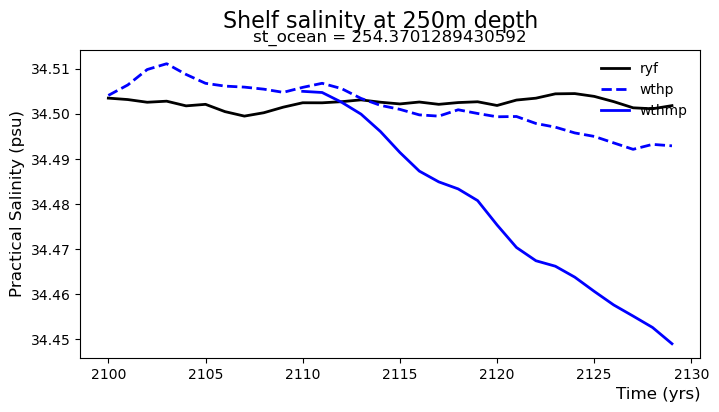

In [32]:
#Example
fig = plt.figure(figsize=(8, 4))
fig.suptitle('Shelf salinity at 250m depth', fontsize=16)
salt_250m_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

## Weddell Sea coastal polynyas shelf region

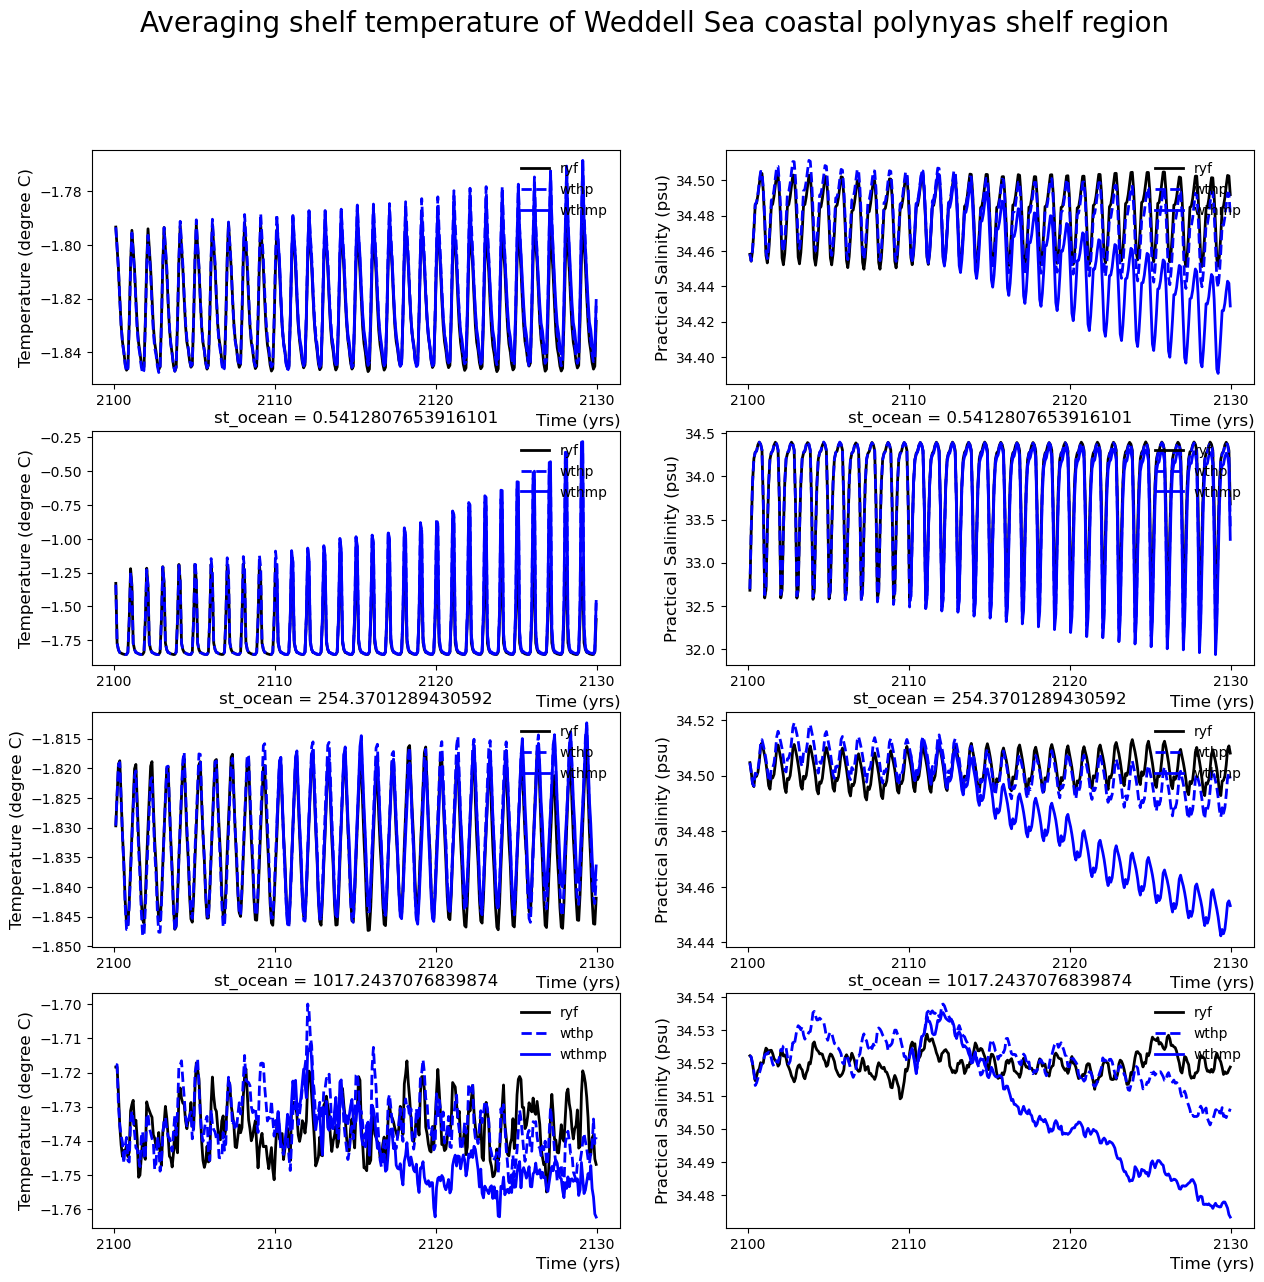

In [24]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature of Weddell Sea coastal polynyas shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Weddell_mean.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Weddell_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Weddell_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

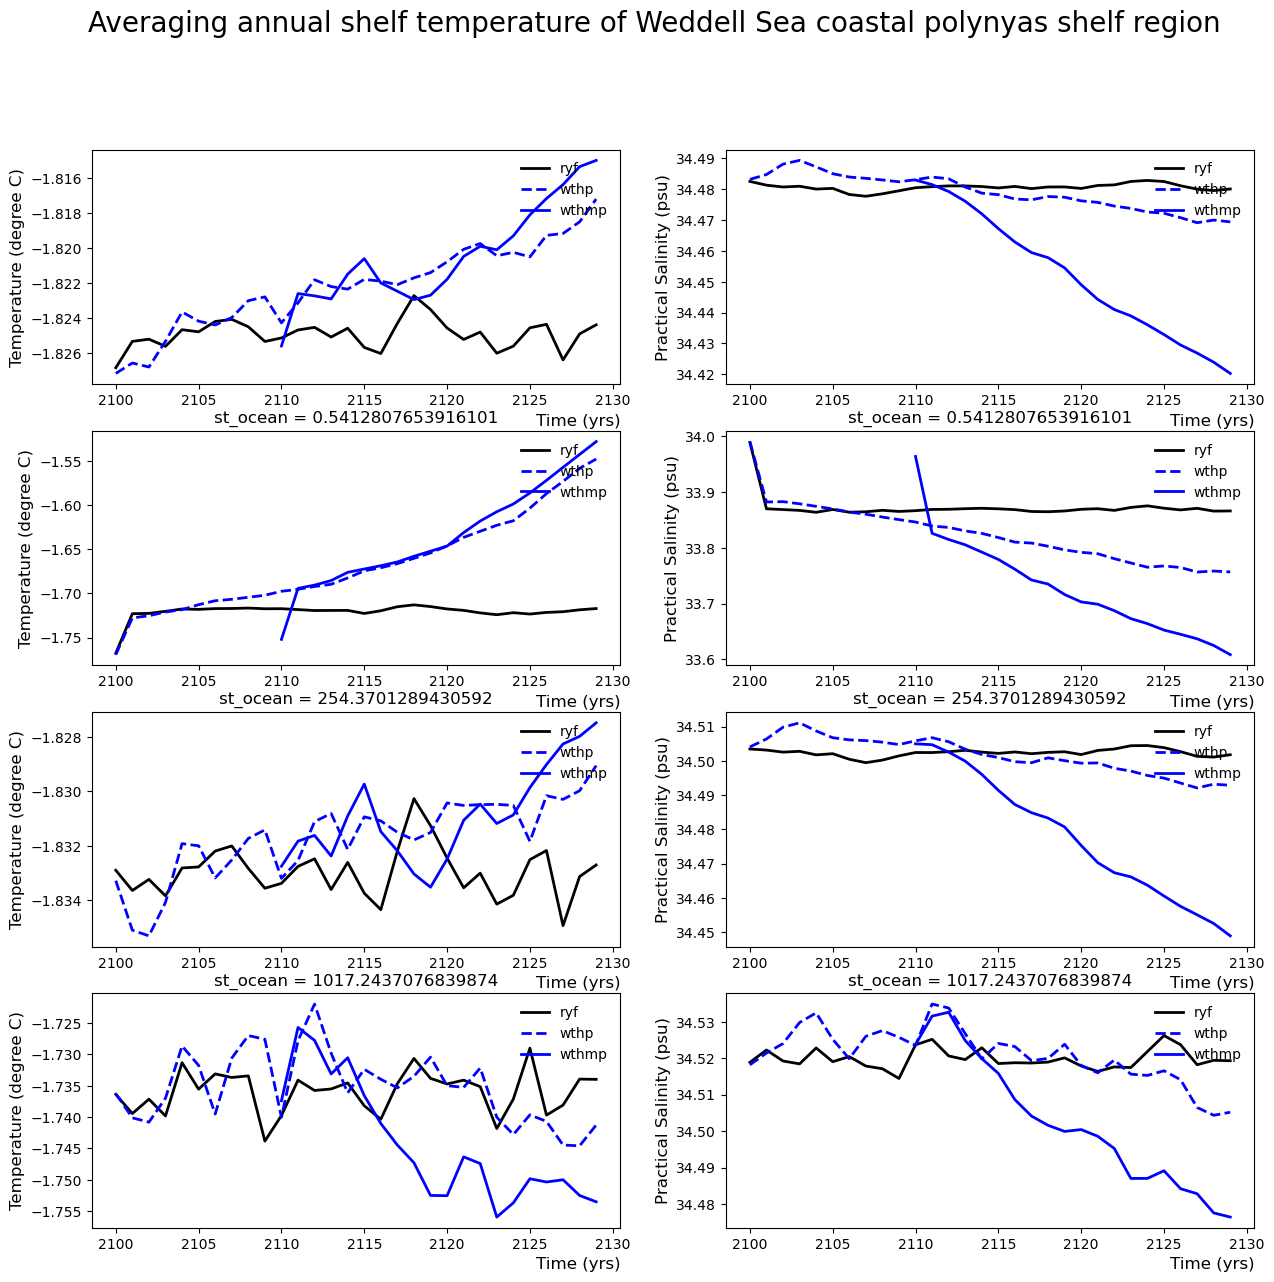

In [16]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature of Weddell Sea coastal polynyas shelf region', fontsize=20)

#Plotting annual mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Weddell_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Weddell_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Weddell_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

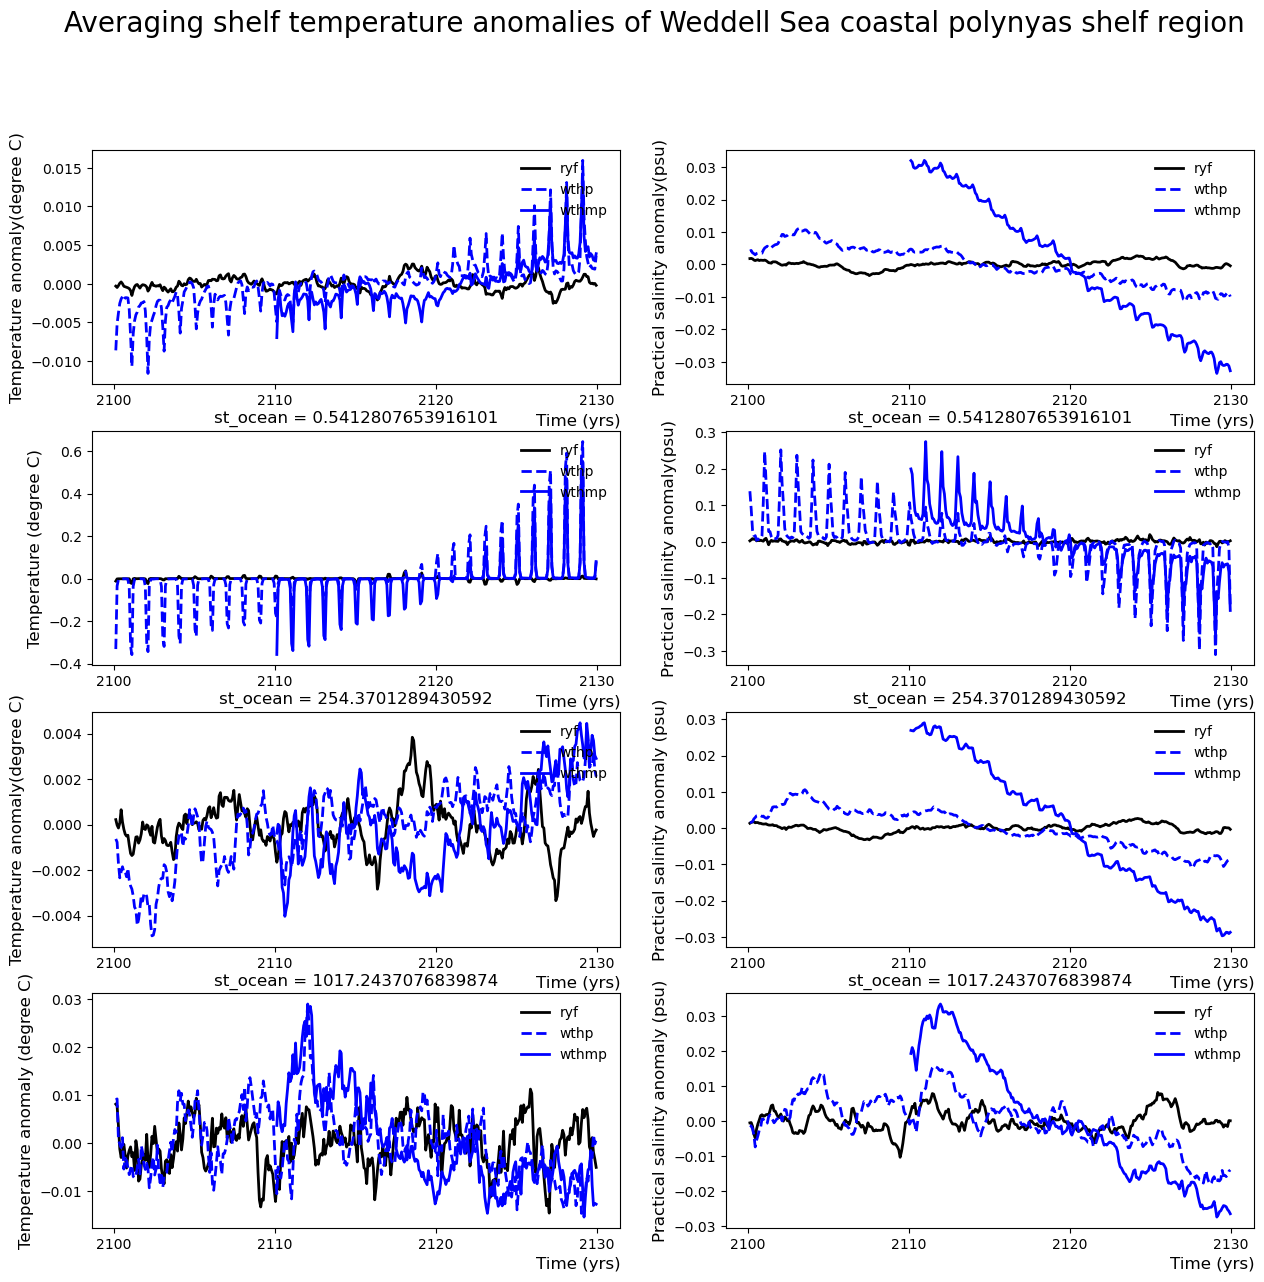

In [28]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature anomalies of Weddell Sea coastal polynyas shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature anomalies over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity anomalies over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature anomalies at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity anomalies at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature anomalies at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity anomalies at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Weddell_anom.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Weddell_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Weddell_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

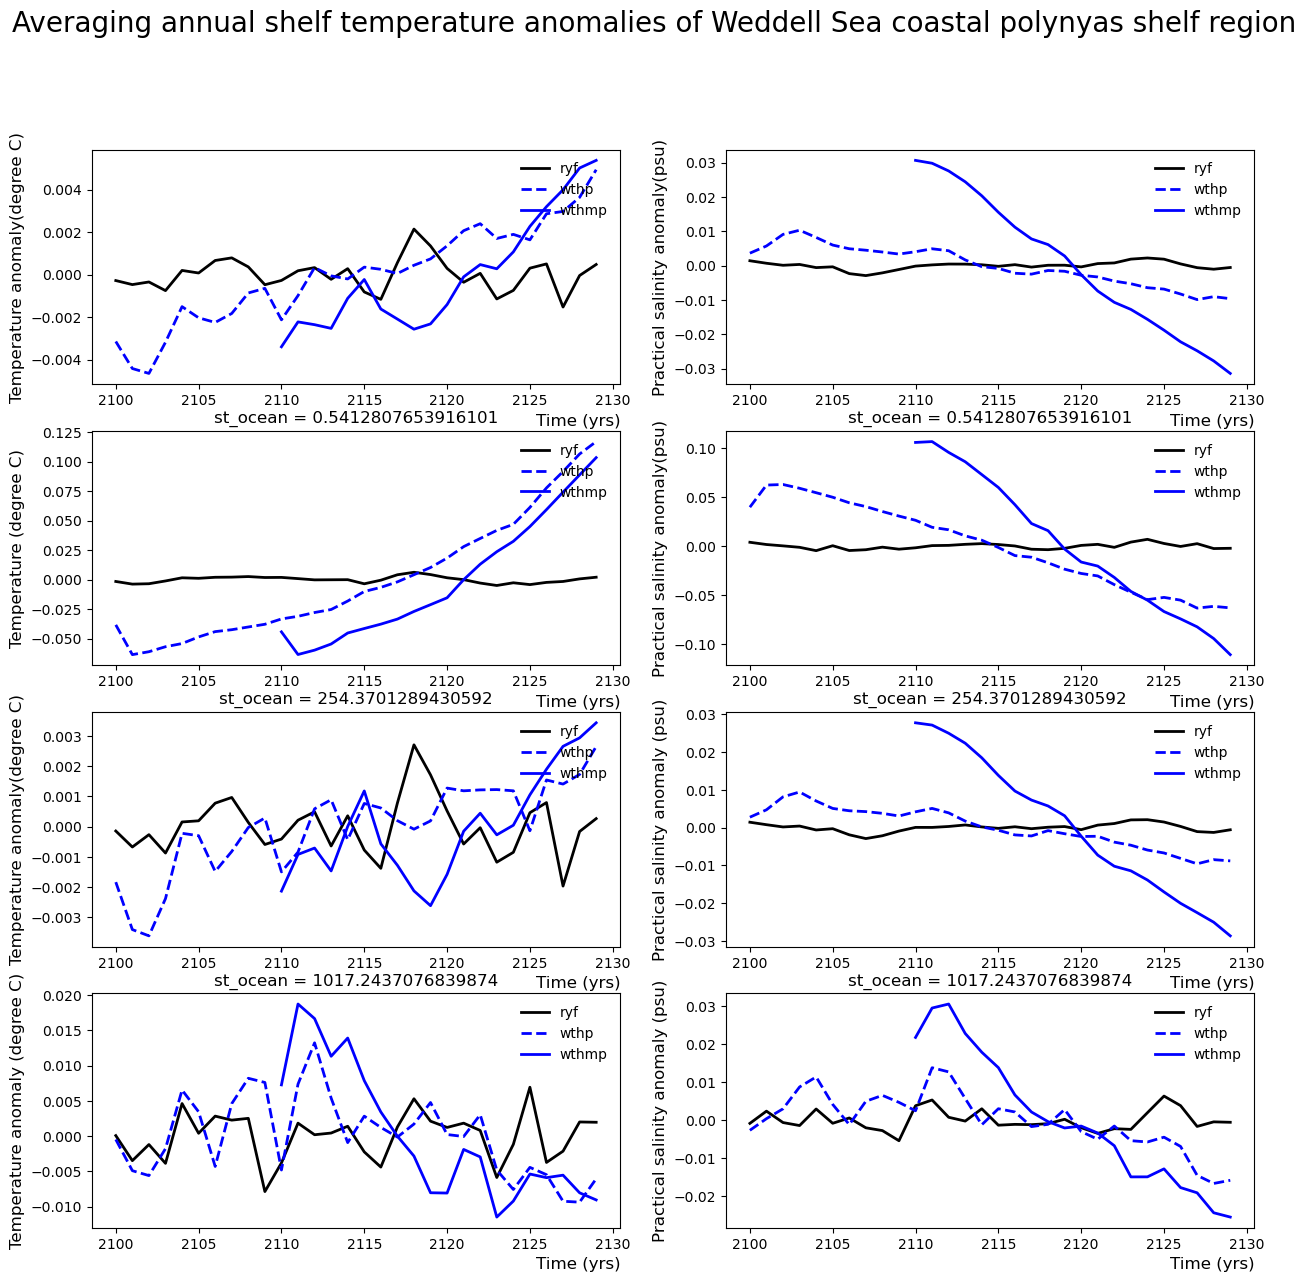

In [20]:
#Plotting annually averaged anomaly time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature anomalies of Weddell Sea coastal polynyas shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature anomalies over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity anomalies over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature anomalies at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity anomalies at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature anomalies at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity anomalies at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Weddell_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Weddell_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Weddell_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

## Ross Sea coastal polynya shelf region

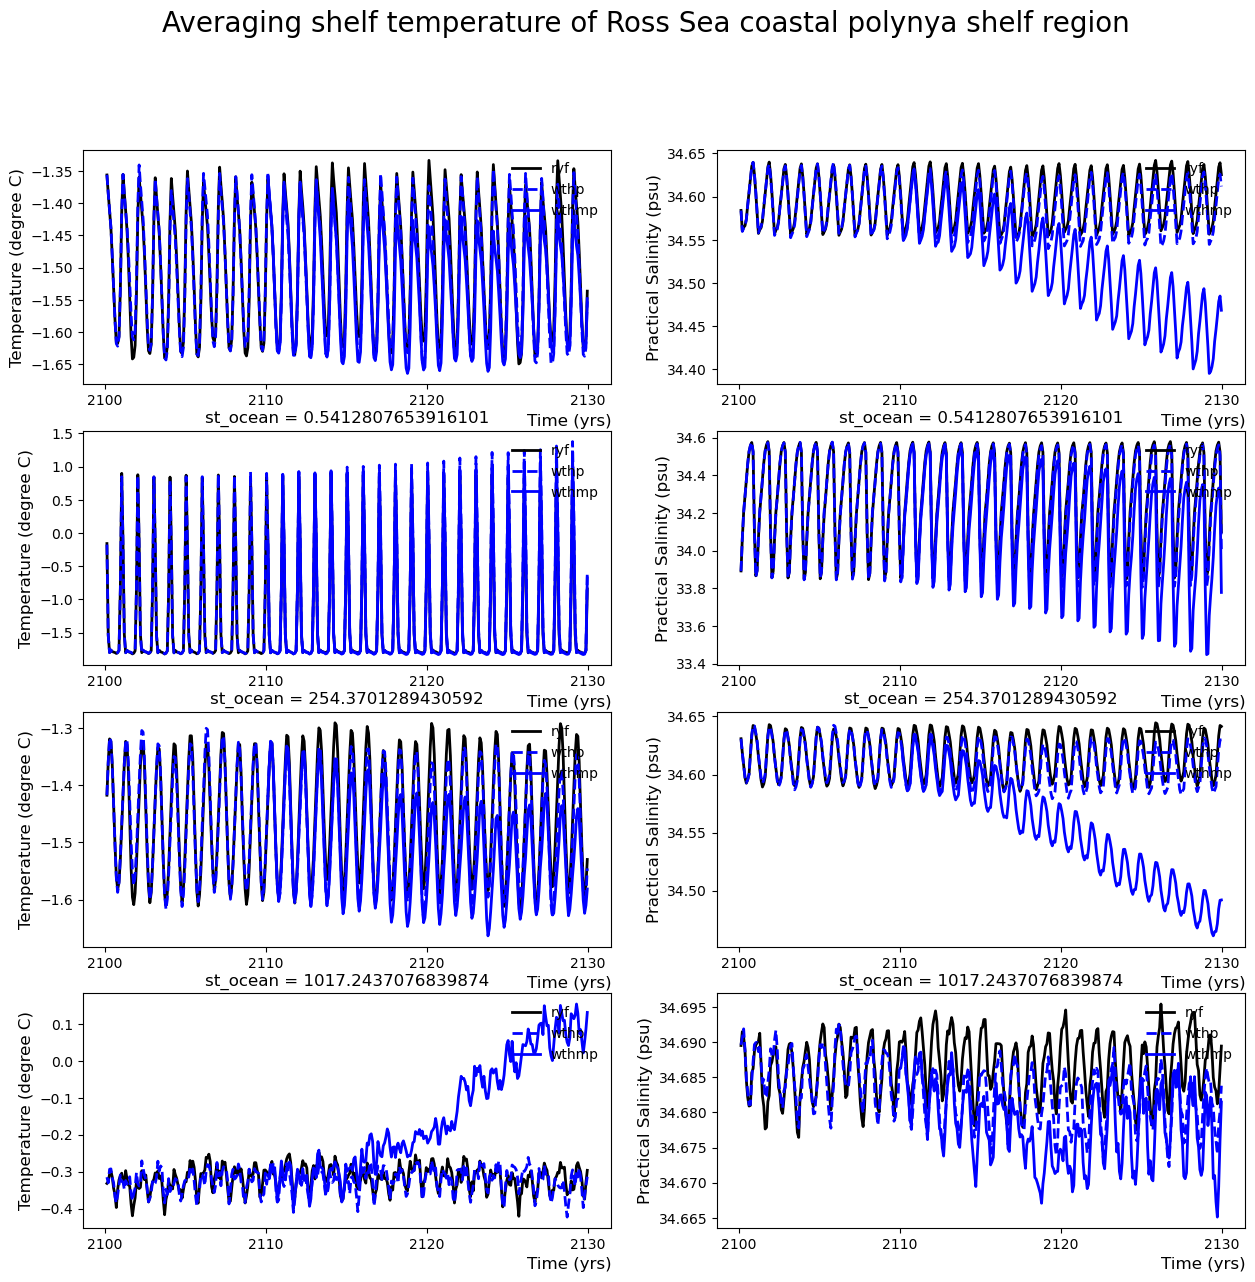

In [25]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature of Ross Sea coastal polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Ross_mean.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Ross_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Ross_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

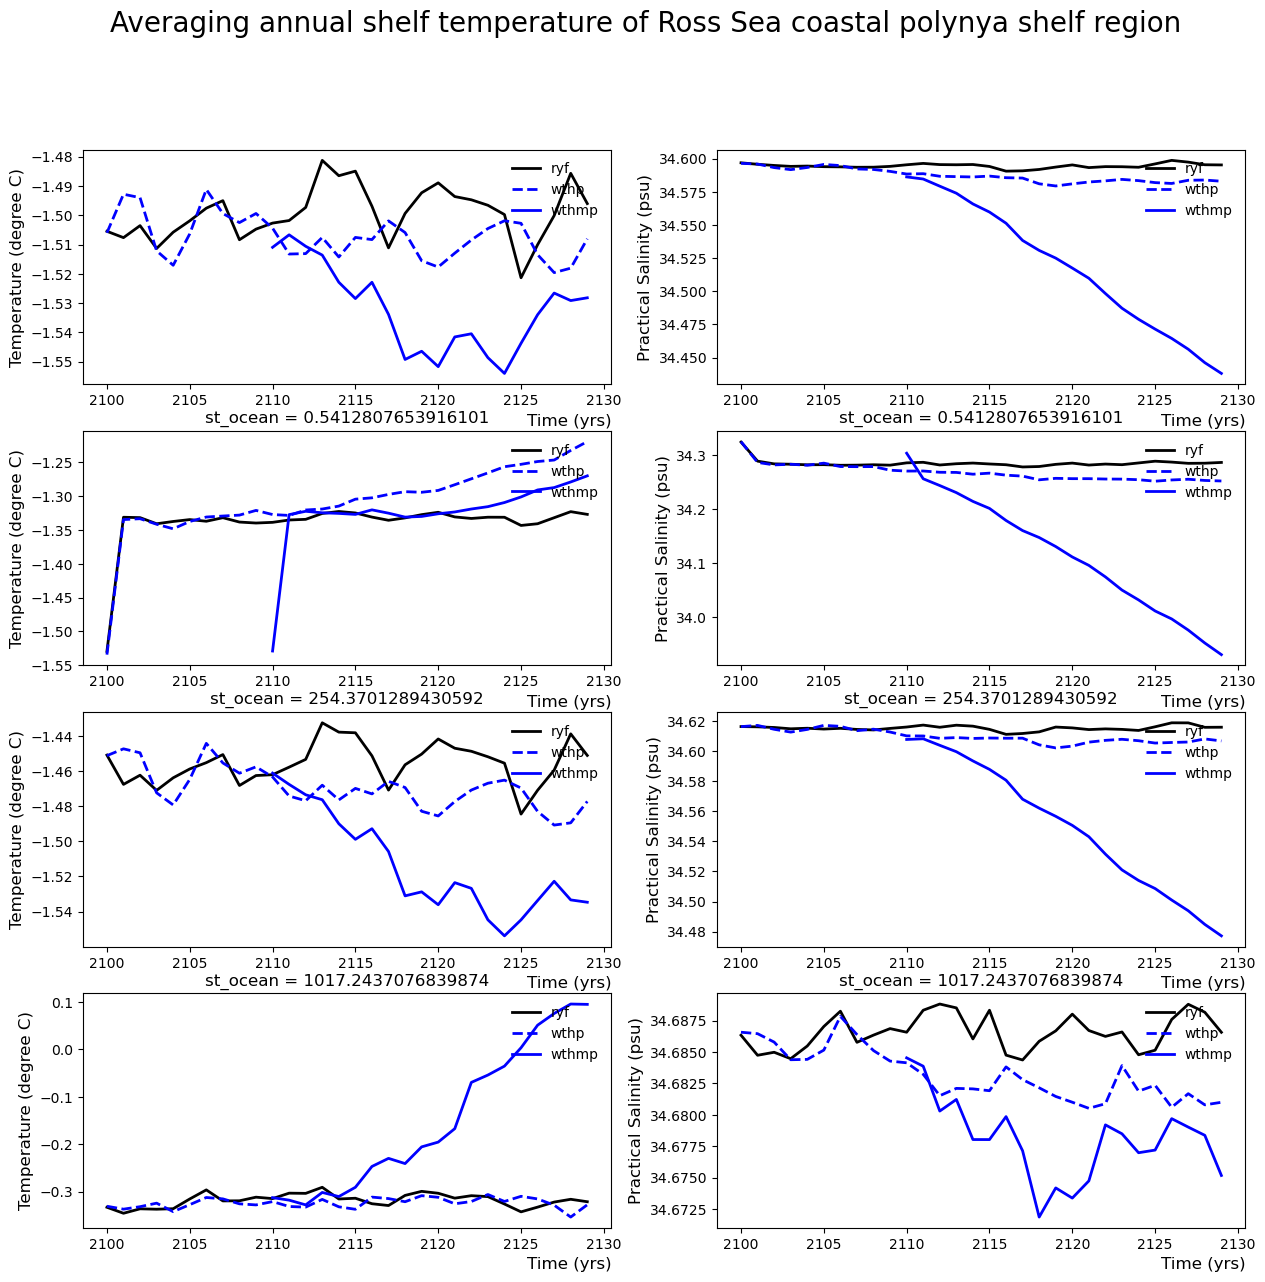

In [17]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature of Ross Sea coastal polynya shelf region', fontsize=20)

#Plotting annual mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Ross_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Ross_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Ross_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

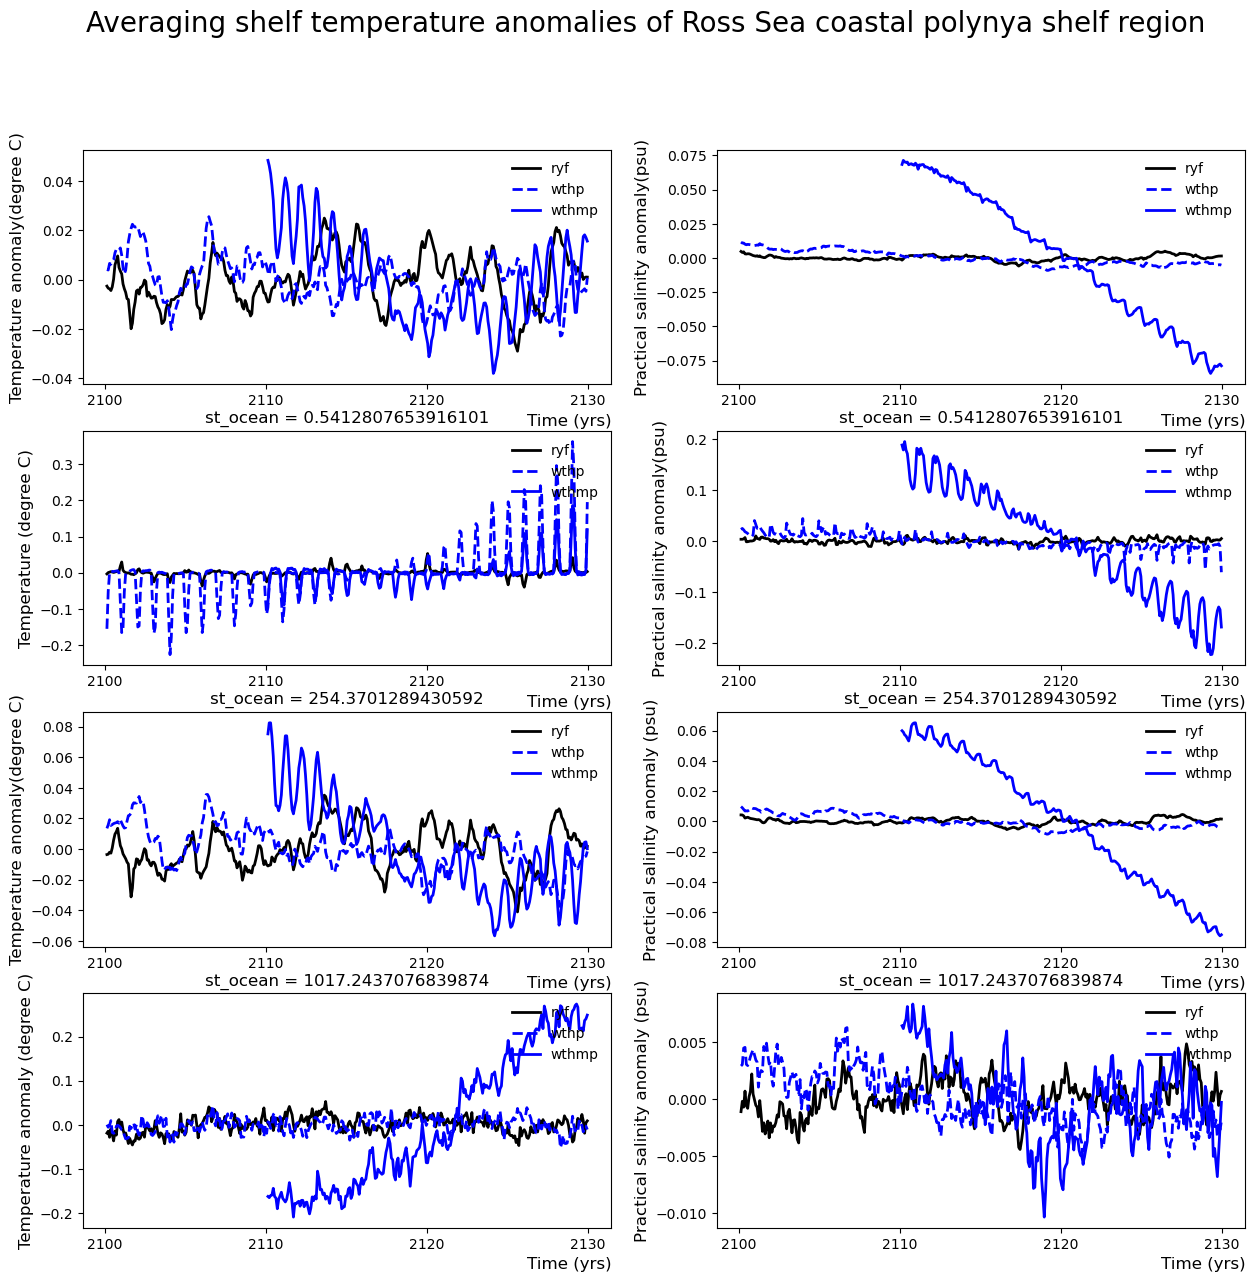

In [29]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature anomalies of Ross Sea coastal polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature anomalies over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Ross_anom.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Ross_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Ross_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity anomalies over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Ross_anom.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Ross_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Ross_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature anomalies at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Ross_anom.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Ross_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Ross_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity anomalies at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Ross_anom.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Ross_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Ross_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature anomalies at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Ross_anom.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Ross_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Ross_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity anomalies at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Ross_anom.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Ross_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Ross_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Ross_anom.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Ross_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Ross_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Ross_anom.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Ross_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Ross_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

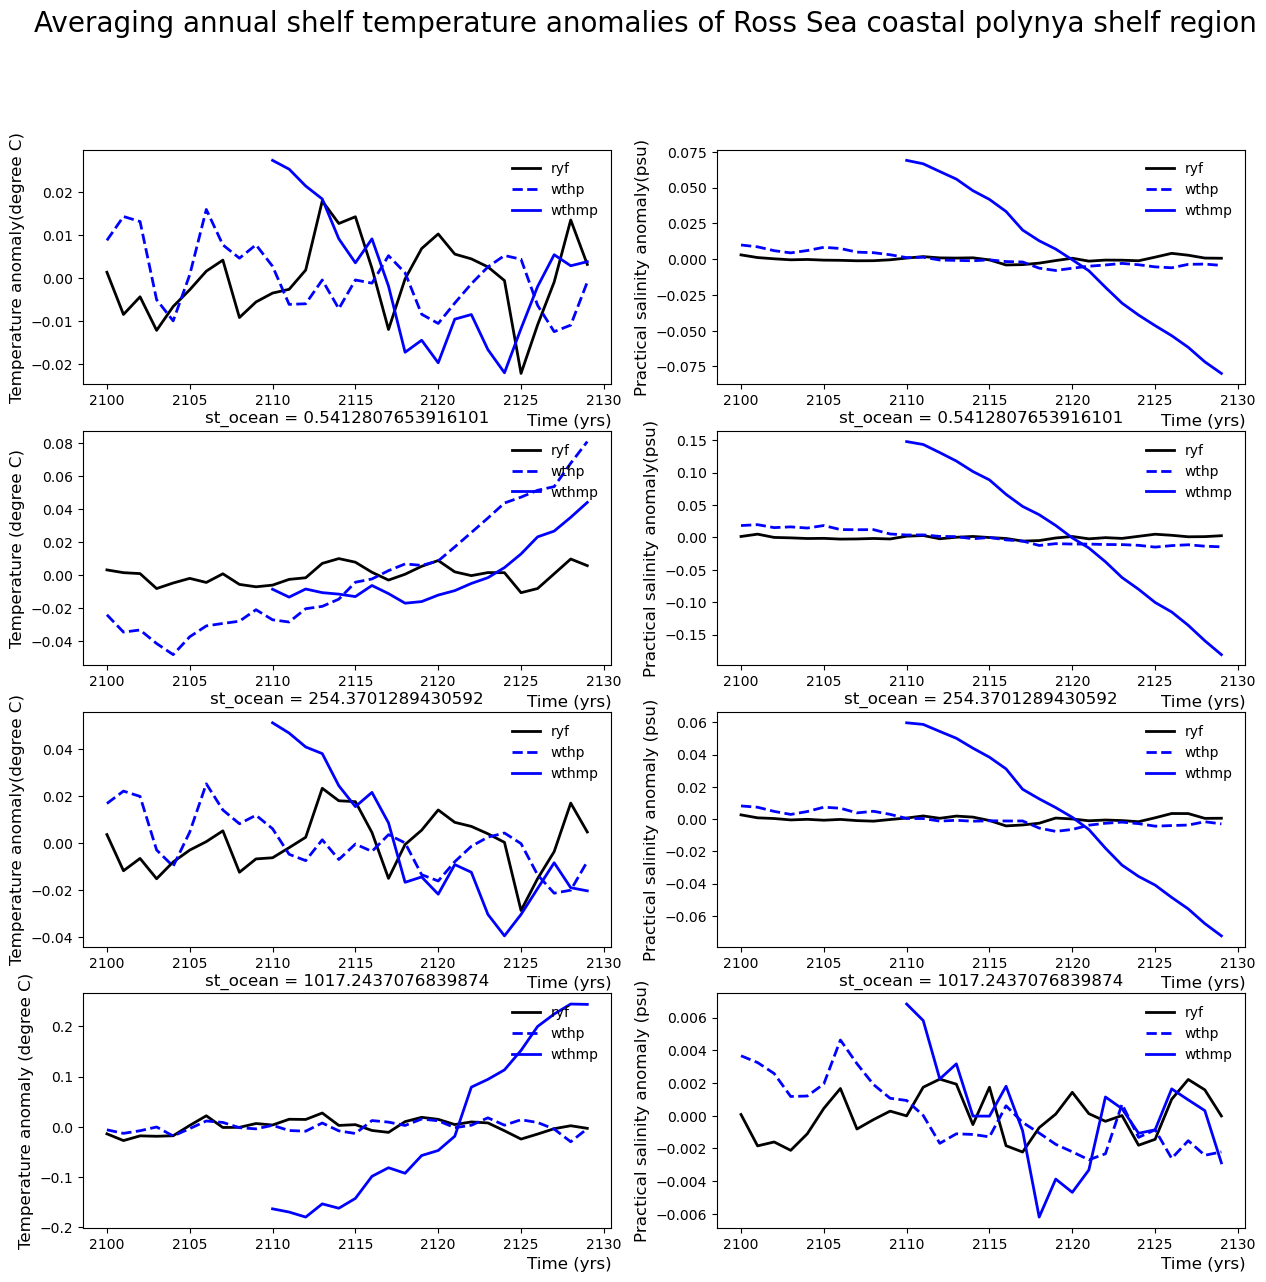

In [21]:
#Plotting annually averaged anomaly time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature anomalies of Ross Sea coastal polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature anomalies over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Ross_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Ross_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Ross_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity anomalies over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Ross_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Ross_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Ross_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature anomalies at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Ross_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Ross_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Ross_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity anomalies at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Ross_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Ross_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Ross_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature anomalies at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Ross_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Ross_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Ross_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity anomalies at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Ross_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Ross_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Ross_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Ross_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Ross_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Ross_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Ross_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Ross_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Ross_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

## Cape Darnley polynya shelf region

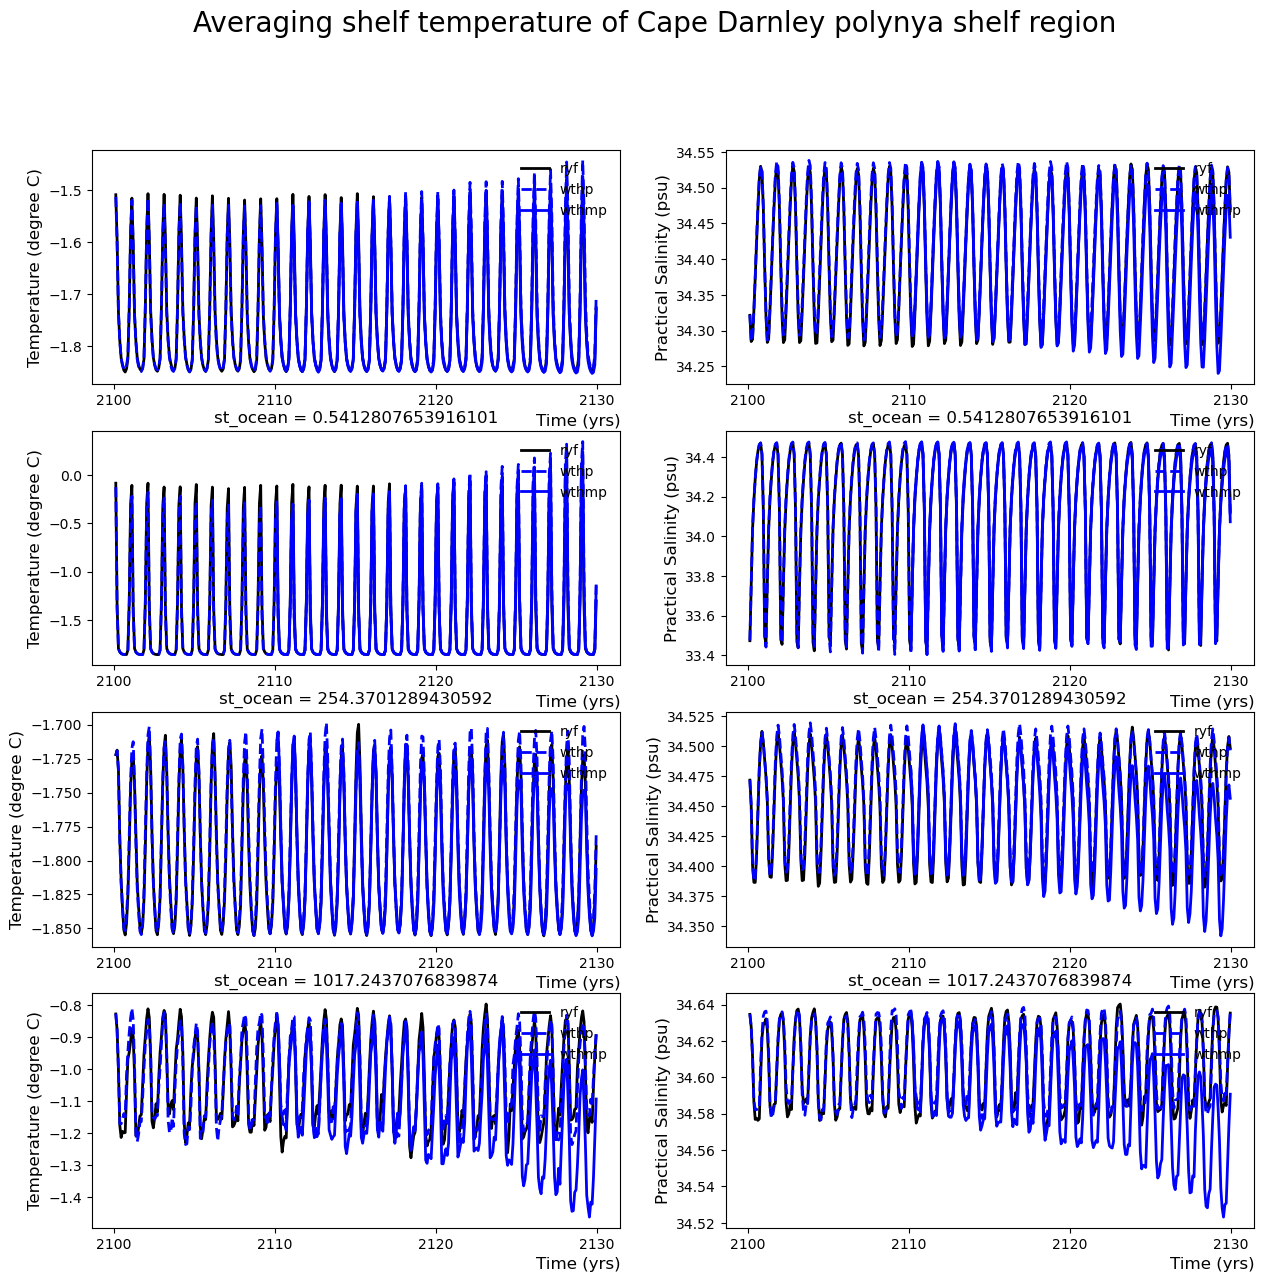

In [26]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature of Cape Darnley polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_CapeD_mean.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_CapeD_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_CapeD_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

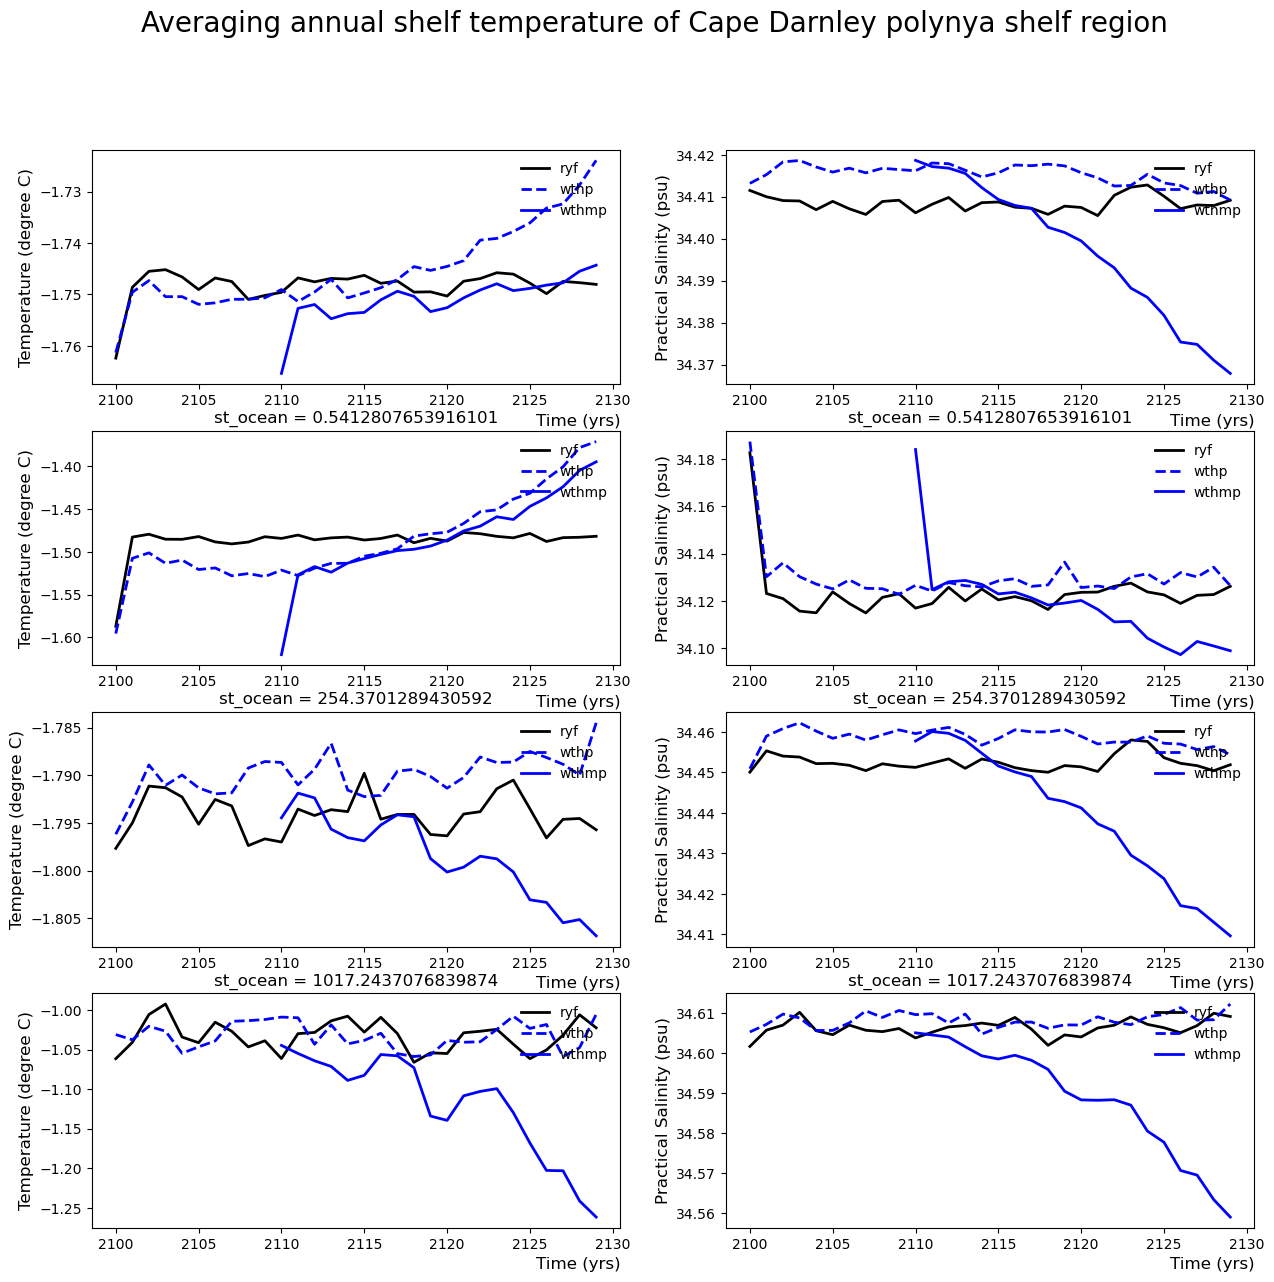

In [18]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature of Cape Darnley polynya shelf region', fontsize=20)

#Plotting annual mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_CapeD_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_CapeD_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_CapeD_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

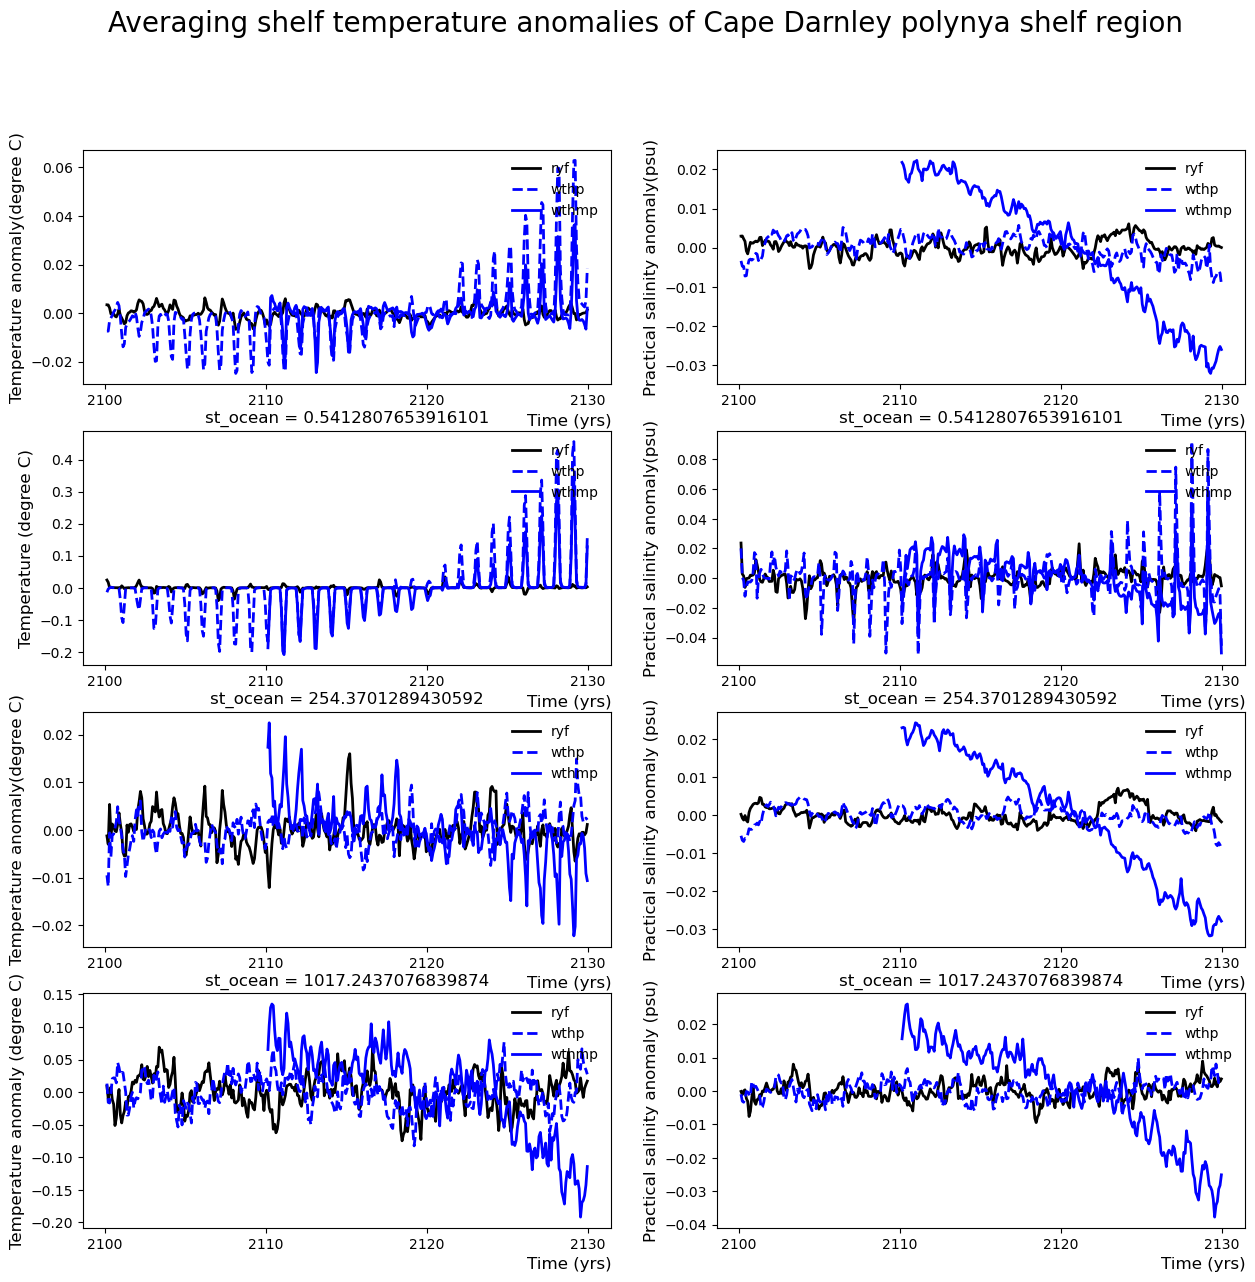

In [30]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature anomalies of Cape Darnley polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature anomalies over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_CapeD_anom.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_CapeD_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_CapeD_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity anomalies over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_CapeD_anom.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_CapeD_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_CapeD_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature anomalies at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_CapeD_anom.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_CapeD_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_CapeD_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity anomalies at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_CapeD_anom.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_CapeD_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_CapeD_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature anomalies at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_CapeD_anom.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_CapeD_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_CapeD_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity anomalies at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_CapeD_anom.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_CapeD_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_CapeD_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_CapeD_anom.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_CapeD_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_CapeD_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_CapeD_anom.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_CapeD_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_CapeD_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

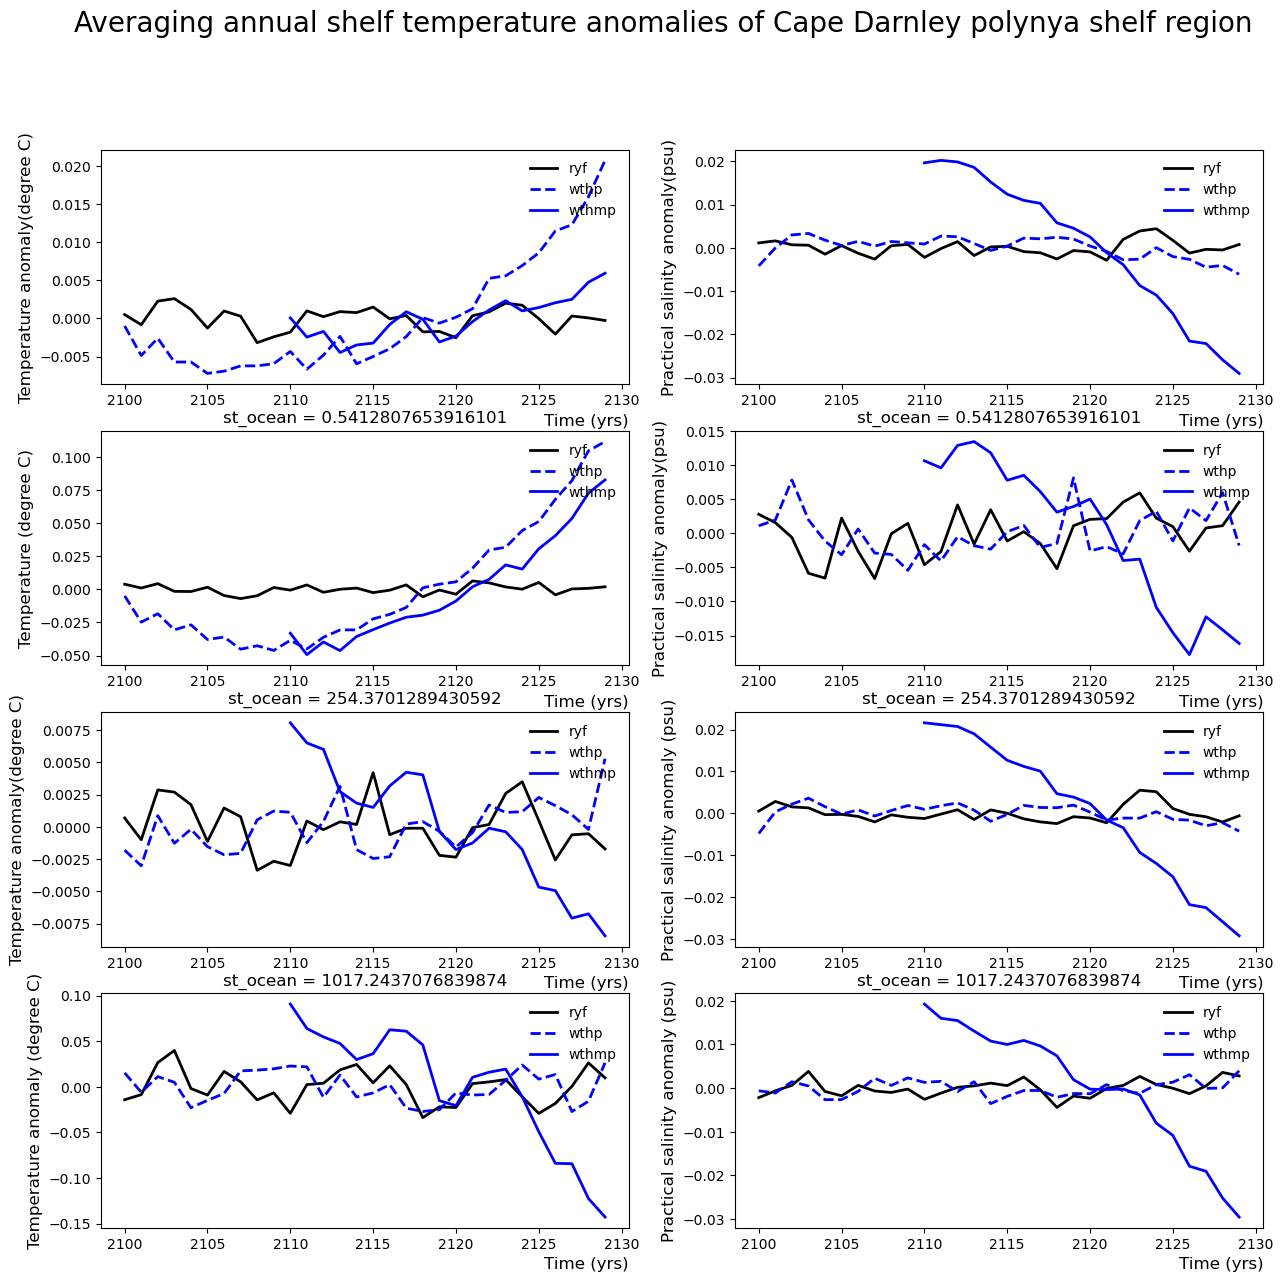

In [22]:
#Plotting annually averaged anomaly time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature anomalies of Cape Darnley polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature anomalies over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_CapeD_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_CapeD_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_CapeD_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity anomalies over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_CapeD_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_CapeD_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_CapeD_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature anomalies at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_CapeD_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_CapeD_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_CapeD_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity anomalies at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_CapeD_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_CapeD_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_CapeD_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature anomalies at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_CapeD_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_CapeD_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_CapeD_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity anomalies at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_CapeD_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_CapeD_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_CapeD_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_CapeD_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_CapeD_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_CapeD_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_CapeD_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_CapeD_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_CapeD_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

## Mertz Glacier Polynya shelf region

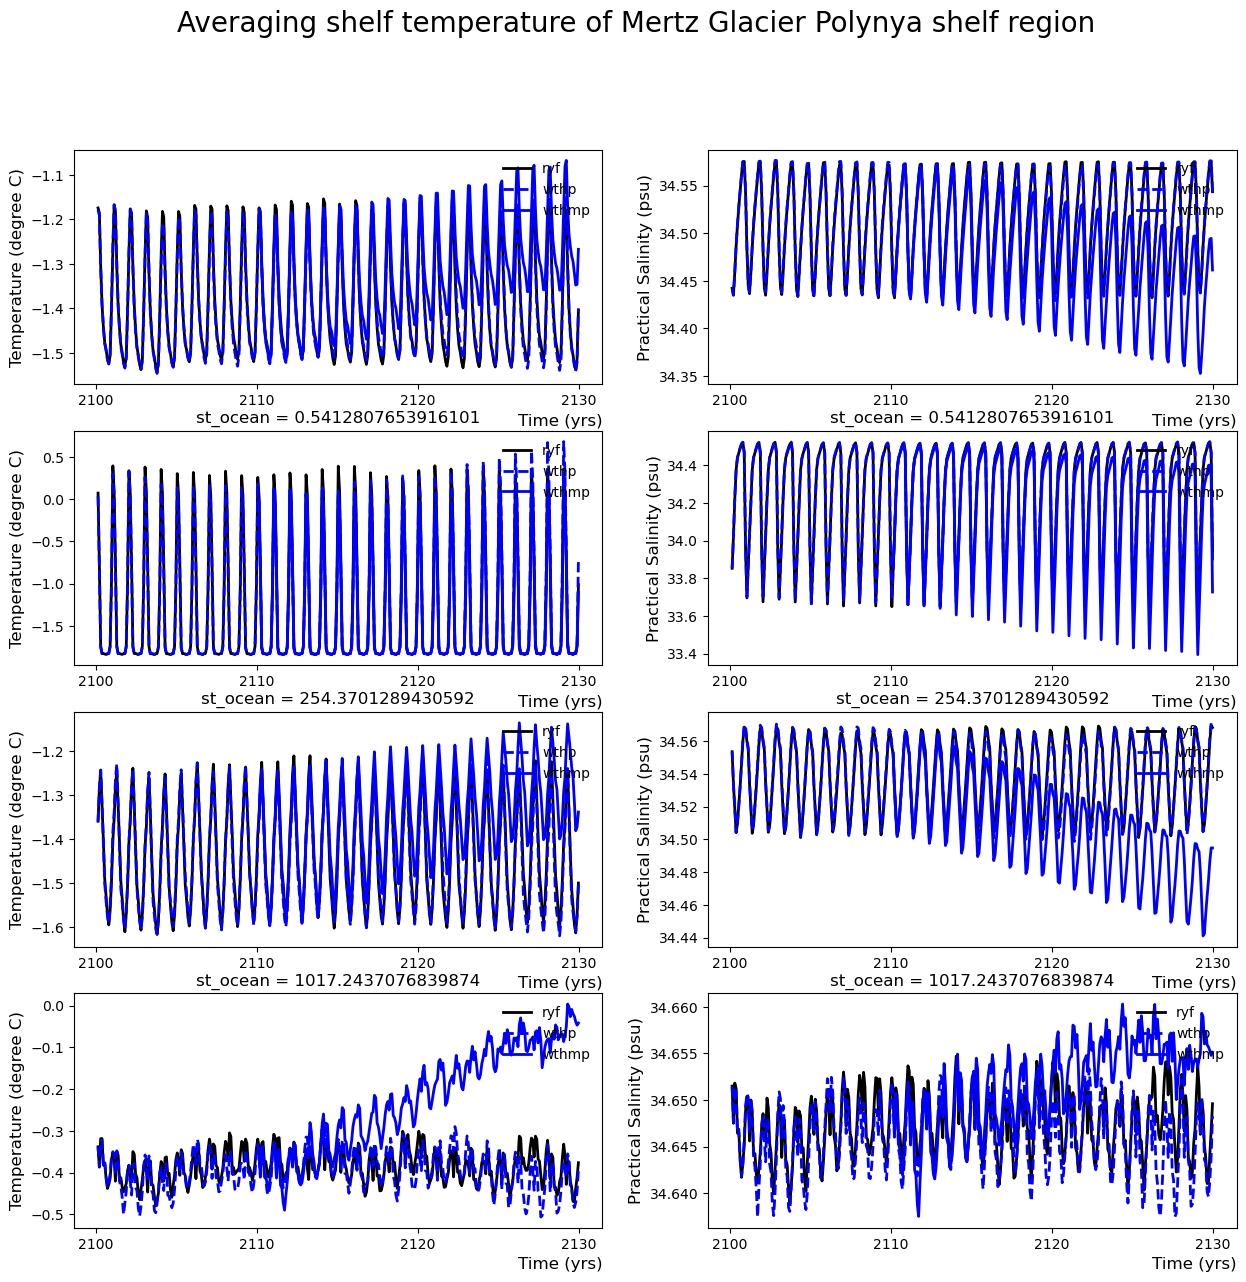

In [27]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature of Mertz Glacier Polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Mertz_mean.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Mertz_mean.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Mertz_mean.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

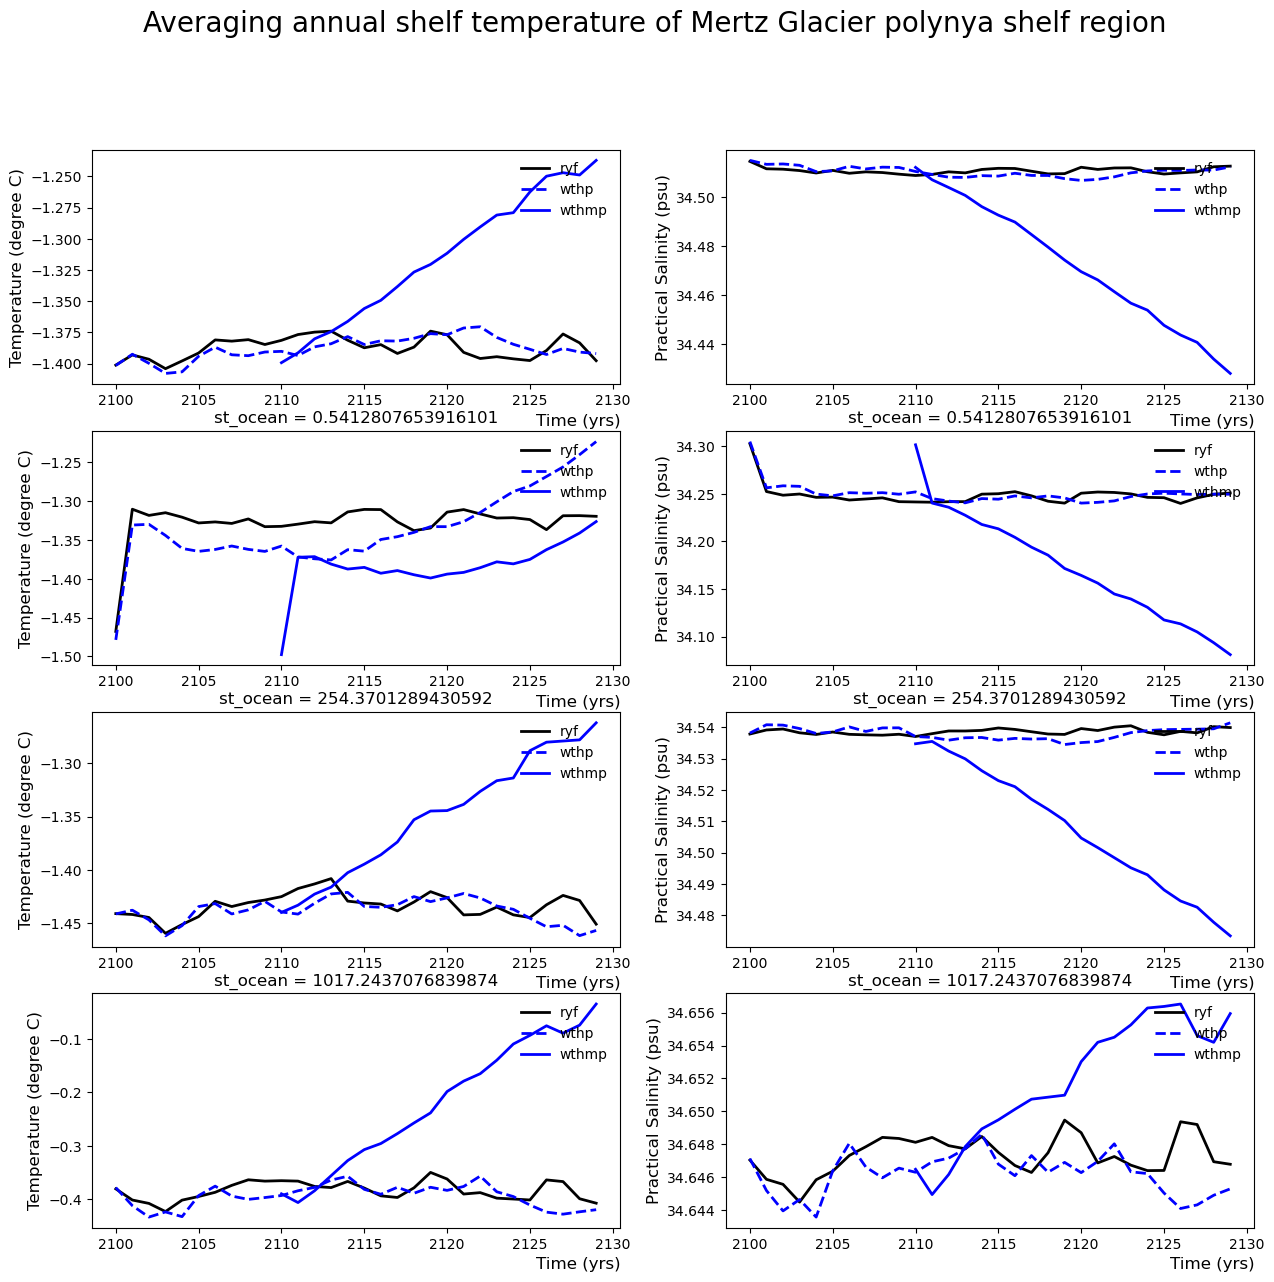

In [19]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature of Mertz Glacier polynya shelf region', fontsize=20)

#Plotting annual mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Mertz_mean_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Mertz_mean_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Mertz_mean_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

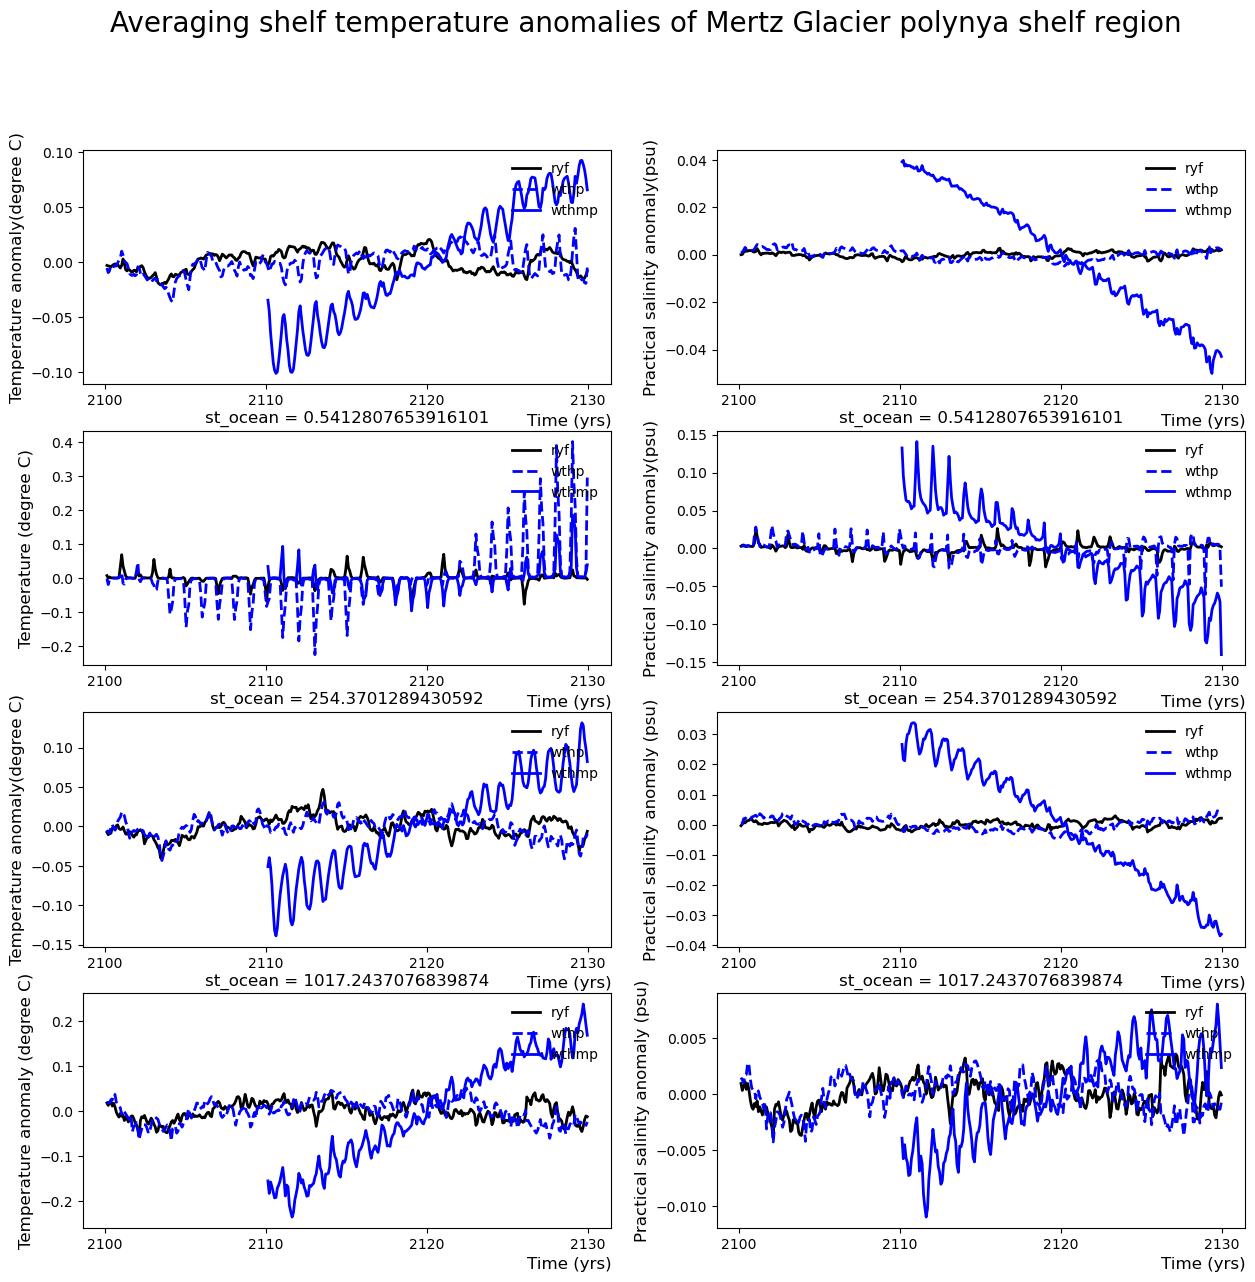

In [31]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging shelf temperature anomalies of Mertz Glacier polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature anomalies over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Mertz_anom.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Mertz_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Mertz_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity anomalies over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Mertz_anom.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Mertz_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Mertz_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature anomalies at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Mertz_anom.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Mertz_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Mertz_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity anomalies at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Mertz_anom.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Mertz_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Mertz_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature anomalies at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Mertz_anom.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Mertz_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Mertz_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity anomalies at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Mertz_anom.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Mertz_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Mertz_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Mertz_anom.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Mertz_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Mertz_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Mertz_anom.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Mertz_anom.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Mertz_anom.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

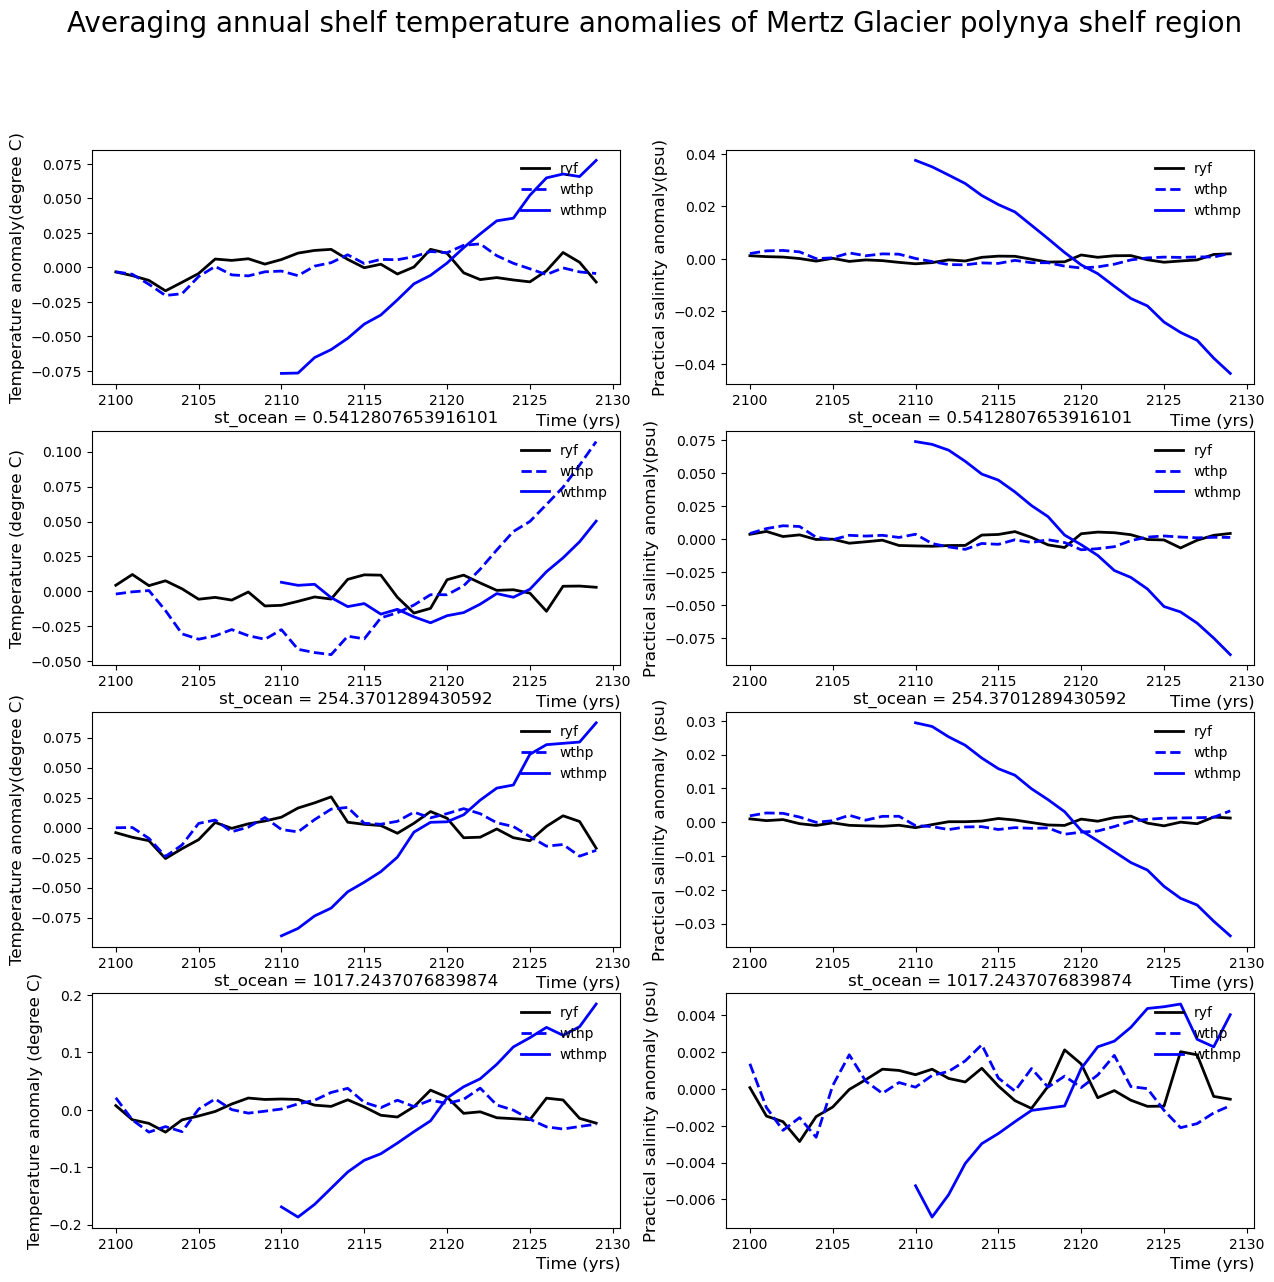

In [23]:
#Plotting annually averaged anomaly time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf temperature anomalies of Mertz Glacier polynya shelf region', fontsize=20)

#Plotting mean shelf temperature averaging over all depths
plt.subplot(4,2,1)
plt.title('Shelf temperature anomalies over all depths', fontsize=13, loc='center')
temp_st_shelf_ryf_Mertz_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_st_shelf_wthp_Mertz_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_st_shelf_wthmp_Mertz_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting mean shelf salinity averaging over all depths
plt.subplot(4,2,2)
plt.title('Shelf salinity anomalies over all depths', fontsize=13, loc='center')
salt_st_shelf_ryf_Mertz_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_st_shelf_wthp_Mertz_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_st_shelf_wthmp_Mertz_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature at surface
plt.subplot(4,2,3)
plt.title('Shelf temperature anomalies at surface', fontsize=13, loc='center')
temp_surface_shelf_ryf_Mertz_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_surface_shelf_wthp_Mertz_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_surface_shelf_wthmp_Mertz_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity at surface
plt.subplot(4,2,4)
plt.title('Shelf salinity anomalies at surface', fontsize=13, loc='center')
salt_surface_shelf_ryf_Mertz_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_surface_shelf_wthp_Mertz_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_surface_shelf_wthmp_Mertz_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly(psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at 250m depth
plt.subplot(4,2,5)
plt.title('Shelf temperature anomalies at 250m depth', fontsize=13, loc='center')
temp_250m_shelf_ryf_Mertz_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_250m_shelf_wthp_Mertz_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_250m_shelf_wthmp_Mertz_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly(degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
plt.title('Shelf salinity anomalies at 250m depth', fontsize=13, loc='center')
salt_250m_shelf_ryf_Mertz_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_250m_shelf_wthp_Mertz_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_250m_shelf_wthmp_Mertz_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf temperature averaging at bottom
plt.subplot(4,2,7)
plt.title('Shelf temperature at bottom', fontsize=13, loc='center')
temp_bottom_shelf_ryf_Mertz_anom_annual.plot(color='black', linewidth=2, label='ryf')
temp_bottom_shelf_wthp_Mertz_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
temp_bottom_shelf_wthmp_Mertz_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Temperature anomaly (degree C)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

#Plotting mean shelf salinity averaging at bottom
plt.subplot(4,2,8)
plt.title('Shelf salinity at bottom', fontsize=13, loc='center')
salt_bottom_shelf_ryf_Mertz_anom_annual.plot(color='black', linewidth=2, label='ryf')
salt_bottom_shelf_wthp_Mertz_anom_annual.plot(color='blue', linewidth=2, linestyle='dashed', label='wthp')
salt_bottom_shelf_wthmp_Mertz_anom_annual.plot(color='blue', linewidth=2, label='wthmp')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical salinity anomaly (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)